# Project 2: Data Representations and Clustering

## Group Members
- Shaira Alam

- Vani Agrawal 

- Dhakshina Ilango

## Package Installation

In [1]:
! pip install numpy
! pip install scikit-learn
! pip install umap-learn
! pip install hdbscan

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np
import plotmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
import numpy as np 
from plotmat import plot_mat
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import hdbscan

# Part 1 - Clustering on Text Data

## Question 1

### 1.1 Report the dimensions of the TF-IDF matrix you obtain.

In [3]:

# Categories for Class 1 and 2
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Loads the dataset
newsgroups_data = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, remove=('headers', 'footers'), random_state=42)

In [4]:
# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(newsgroups_data.data)

# Dimensions of the TD-IDF matrix
tfidf_dims = X_train_tfidf.shape

print("Dimensions of the TD-IDF matrix: ",tfidf_dims)

Dimensions of the TD-IDF matrix:  (7882, 23522)


## Question 2

### 2.1 Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix.

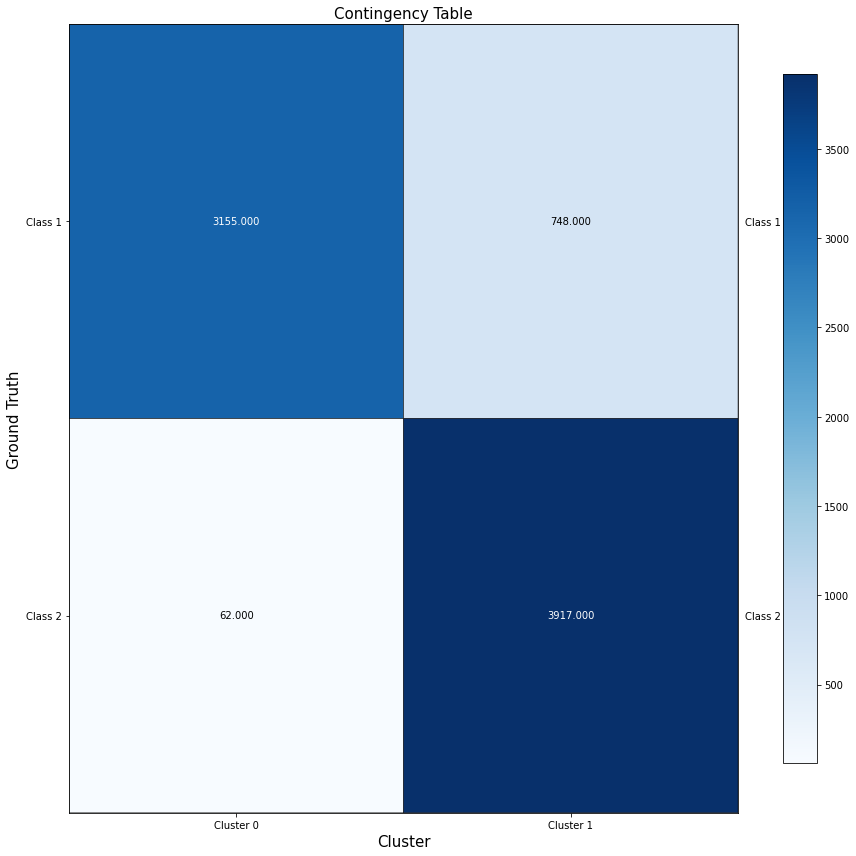

In [5]:
# K-means clustering with k = 2 using the TF-IDF data
k = 2
km = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30)
clusters = km.fit_predict(X_train_tfidf)

# Ground truth labels
ground_truth = [int(i/4) for i in newsgroups_data.target]

mat = contingency_matrix(ground_truth, clusters)

# Visualizing the matrix using plotmat.py
xlabels = ['Cluster 0', 'Cluster 1']
ylabels = ['Class 1', 'Class 2']
plotmat.plot_mat(mat, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(12,12), title="Contingency Table")


### 2.2 Does the contingency matrix have to be square-shaped?

No, the contingency matrix does not have to be square shaped since the contingency matrix is a matrix where the rows represent the ground truth labels and the columns represent the predicted cluster labels, so therefore the contingency matrix can be rectangular shaped as well. However, in this scenario, since we only had 2 clusters and 2 ground truth labels, the contingency matrix was square-shaped.

## Question 3

### 3.1 Report the 5 clustering measures explained in the introduction for K-means clustering.

### 1. Homogeneity 
- is a measure of how “pure” the clusters are. If each cluster contains only data points from a single class, the homogeneity is satisfied.

In [6]:
h_score= homogeneity_score(ground_truth,clusters)
print("Homogeneity Score:", h_score)

Homogeneity Score: 0.568013245785168


### 2. Completeness 
- indicates how much of the data points of a class are assigned to the same cluster.

In [7]:
c_score = completeness_score(ground_truth,clusters)
print("Completeness:", c_score)

Completeness: 0.5822303423168675


### 3. V-measure
- is the harmonic average of homogeneity score and completeness score.

In [8]:
v_score = v_measure_score(ground_truth,clusters)
print("V-measure:", v_score)

V-measure: 0.5750339318643112


### 4. Adjusted Rand Index 
- is similar to accuracy, which computes similarity between the clustering labels and ground truth labels. This method counts all pairs of points that both fall either in the same cluster and the same class or in different clusters and different classes.

In [9]:
adj_ri = adjusted_rand_score(ground_truth,clusters)
print("Adjusted Rand Index:", adj_ri)

Adjusted Rand Index: 0.631133674855338


### 5. Adjusted Mutual Information Score 
- measures the mutual information between the cluster label distribution and the ground truth label distributions.

In [10]:
adj_mi = adjusted_mutual_info_score(ground_truth,clusters)
print("Adjusted Mutual Information Score:", adj_mi)

Adjusted Mutual Information Score: 0.5749945448304503


## Question 4

### 4.1 Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

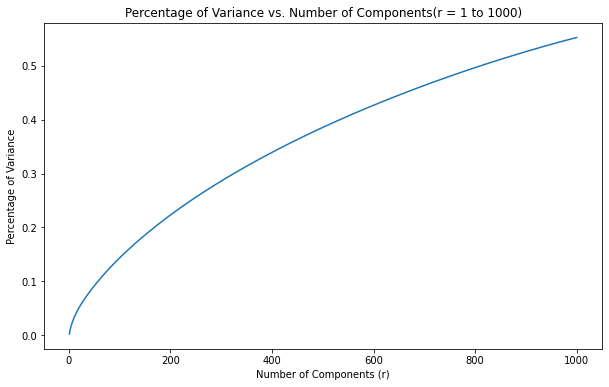

In [11]:
# Truncated SVD
r = 1000
svd = TruncatedSVD(n_components=r, random_state=0)
svd.fit_transform(X_train_tfidf)

# Cumulative explained variance ratio for each component
explained_variance = svd.explained_variance_ratio_.cumsum()

# R components
X_vals = np.array(range(1, r+1))

# Plot of the percentage of variance vs number of components
plt.figure(figsize=(10,6))
plt.plot(X_vals, explained_variance)
plt.title("Percentage of Variance vs. Number of Components(r = 1 to 1000)")
plt.xlabel("Number of Components (r)")
plt.ylabel("Percentage of Variance")
plt.show()

## Question 5

### 5.1 Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF.

In [12]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for SVD
svd_h_score, svd_c_score, svd_v_score, svd_ajd_ri, svd_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # SVD
    svd = TruncatedSVD(n_components=r, random_state=0)
    X_train_svd = svd.fit_transform(X_train_tfidf)

    # K-Means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    svd_cluster = km.fit_predict(X_train_svd)

    # Clusters metric scores for SVD
    svd_h_score.append(homogeneity_score(ground_truth, svd_cluster))
    svd_c_score.append(completeness_score(ground_truth, svd_cluster))
    svd_v_score.append(v_measure_score(ground_truth, svd_cluster))
    svd_ajd_ri.append(adjusted_rand_score(ground_truth, svd_cluster))
    svd_adj_mi.append(adjusted_mutual_info_score(ground_truth, svd_cluster))

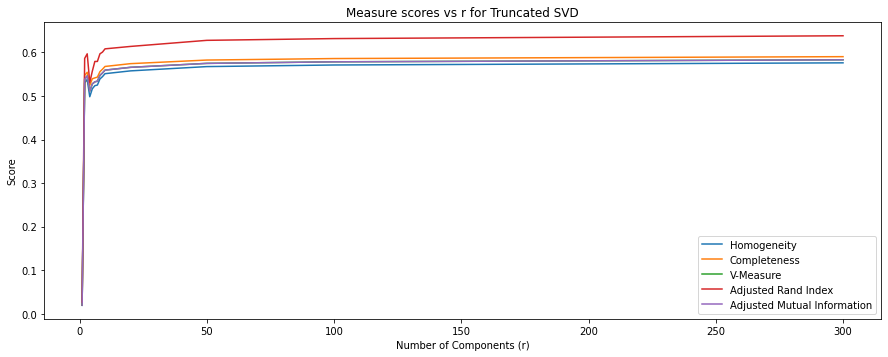

In [13]:
# Truncated SVD Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, svd_h_score, label='Homogeneity')
plt.plot(r_vals, svd_c_score, label='Completeness')
plt.plot(r_vals, svd_v_score, label='V-Measure')
plt.plot(r_vals, svd_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, svd_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for Truncated SVD")
plt.legend()

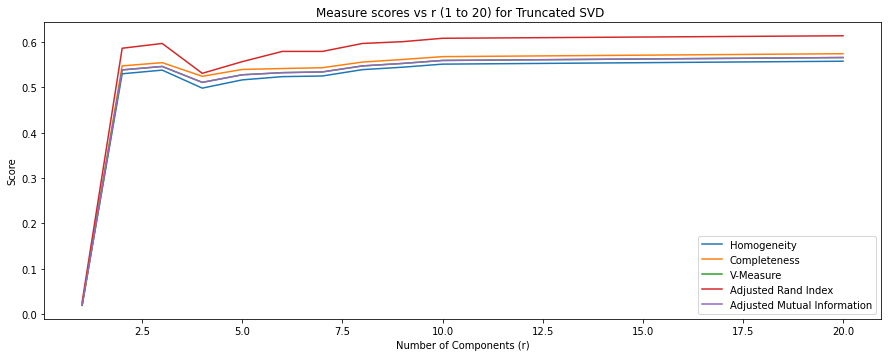

In [14]:
# Zoomed Truncated SVD plot (r = 1 to 20)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:11], svd_h_score[:11], label='Homogeneity')
plt.plot(r_vals[:11], svd_c_score[:11], label='Completeness')
plt.plot(r_vals[:11], svd_v_score[:11], label='V-Measure')
plt.plot(r_vals[:11], svd_ajd_ri[:11], label='Adjusted Rand Index')
plt.plot(r_vals[:11], svd_adj_mi[:11], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 20) for Truncated SVD ")
plt.legend()

In [15]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for NMF
nmf_h_score, nmf_c_score, nmf_v_score, nmf_ajd_ri, nmf_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # NMF
    nmf = NMF(n_components=r, random_state=0, max_iter=2000)
    X_train_nmf = nmf.fit_transform(X_train_tfidf)

    # K-means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    nmf_cluster = km.fit_predict(X_train_nmf)

    # Clusters metric scores for NMF
    nmf_h_score.append(homogeneity_score(ground_truth, nmf_cluster))
    nmf_c_score.append(completeness_score(ground_truth, nmf_cluster))
    nmf_v_score.append(v_measure_score(ground_truth, nmf_cluster))
    nmf_ajd_ri.append(adjusted_rand_score(ground_truth, nmf_cluster))
    nmf_adj_mi.append(adjusted_mutual_info_score(ground_truth, nmf_cluster))

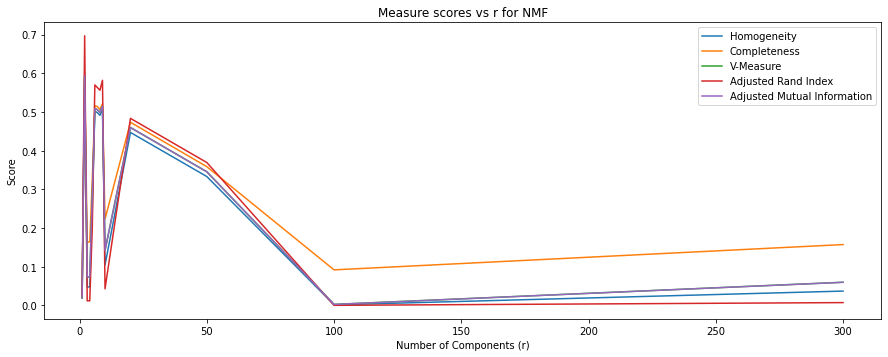

In [16]:
# NMF Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, nmf_h_score, label='Homogeneity')
plt.plot(r_vals, nmf_c_score, label='Completeness')
plt.plot(r_vals, nmf_v_score, label='V-Measure')
plt.plot(r_vals, nmf_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, nmf_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for NMF")
plt.legend()

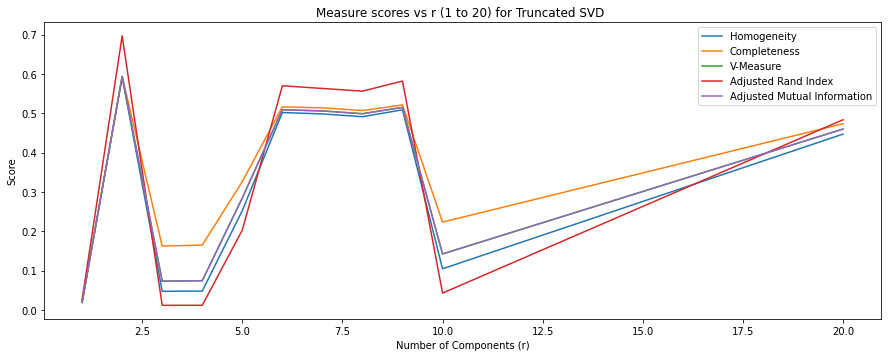

In [17]:
# Zoomed NMF plot (r = 1 to 20)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:11], nmf_h_score[:11], label='Homogeneity')
plt.plot(r_vals[:11], nmf_c_score[:11], label='Completeness')
plt.plot(r_vals[:11], nmf_v_score[:11], label='V-Measure')
plt.plot(r_vals[:11], nmf_ajd_ri[:11], label='Adjusted Rand Index')
plt.plot(r_vals[:11], nmf_adj_mi[:11], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 20) for Truncated SVD ")
plt.legend()

### 5.2 Report a good choice of r for SVD and NMF respectively.

According to the graphs, the best rank for SVD is 20 and the best rank for NMF is 2.

## Question 6

### 6.1 How do you explain the non-monotonic behavior of the measures as r increases?

*incomplete*

## Question 7

### 7.1 Are these measures on average better than those computed in Question 3?

*incomplete*

## Question 8

### 8.1 Visualize the clustering results for SVD with your optimal choice of r for K-Means clustering

Text(0.5, 1.0, 'Ground Truth K-Means clustering (SVD)')

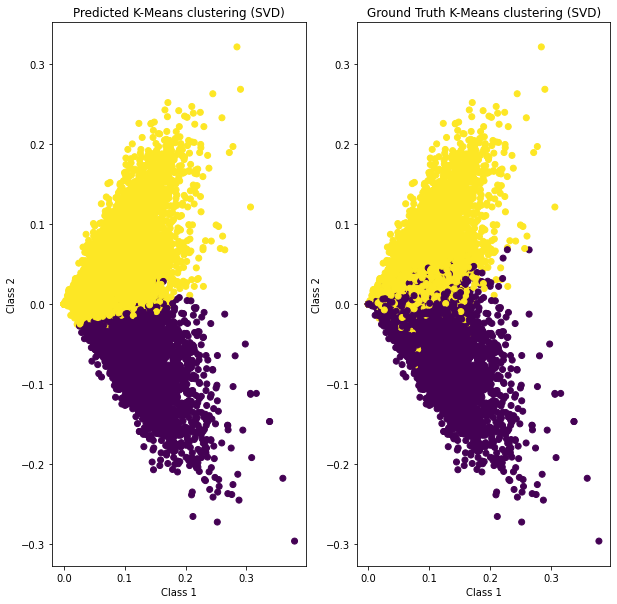

In [18]:
# Optimal choice of r
opt_r_svd = 20

# SVD
svd = TruncatedSVD(n_components=opt_r_svd, random_state=0)
X_train_svd = svd.fit_transform(X_train_tfidf)

# K-Means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
svd_cluster = km.fit_predict(X_train_svd)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=svd_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (SVD)')

plt.subplot(122)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (SVD)')

### 8.2 Visualize the clustering results for NMF with your choice of r for K-Means clustering.

Text(0.5, 1.0, 'Ground Truth K-Means clustering (NMF)')

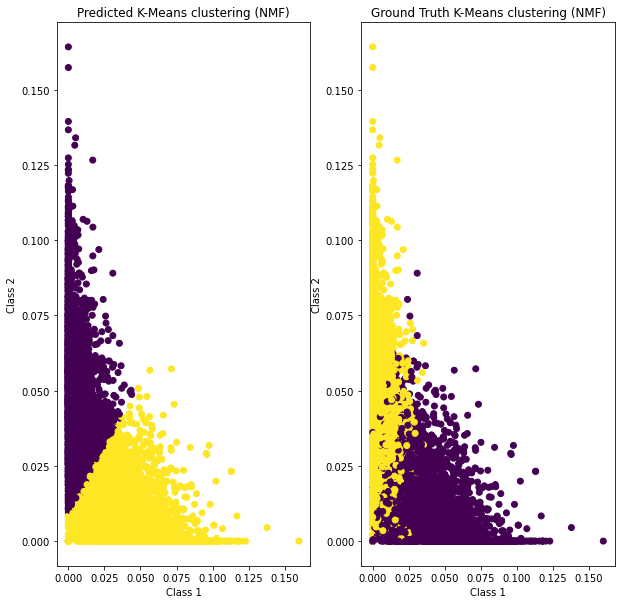

In [19]:
# Optimal choice of r
opt_r_nmf = 2

# NMF
nmf = NMF(n_components=opt_r_nmf, random_state=0, max_iter=2000)
X_train_nmf = nmf.fit_transform(X_train_tfidf)

# K-means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
nmf_cluster = km.fit_predict(X_train_nmf)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=nmf_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (NMF)')

plt.subplot(122)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (NMF)')

## Question 9

### 9.1 What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

#### QUESTION 10: Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20 . Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).

- The dimensions of the TF-IDF matrix is (18846, 45365)
- From Q5 we got optimal value of r as 2 for NMF and 300 for SVD therefore these values of r will be used for NMF and SVD respectively 

In [20]:
# Load the dataset
newsgroups_data20 = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers'), random_state=42)

In [21]:
# TF-IDF Vectorizer
tfidf_vect20 = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf20 = tfidf_vect20.fit_transform(newsgroups_data20.data)

print("Dimensions of the TD-IDF matrix: ", X_train_tfidf20.shape)

Dimensions of the TD-IDF matrix:  (18846, 45365)


### NMF

In [22]:
# NMF
nmf20 = NMF(n_components=2, random_state=0, max_iter=2000)
X_train_nmf20 = nmf20.fit_transform(X_train_tfidf20)

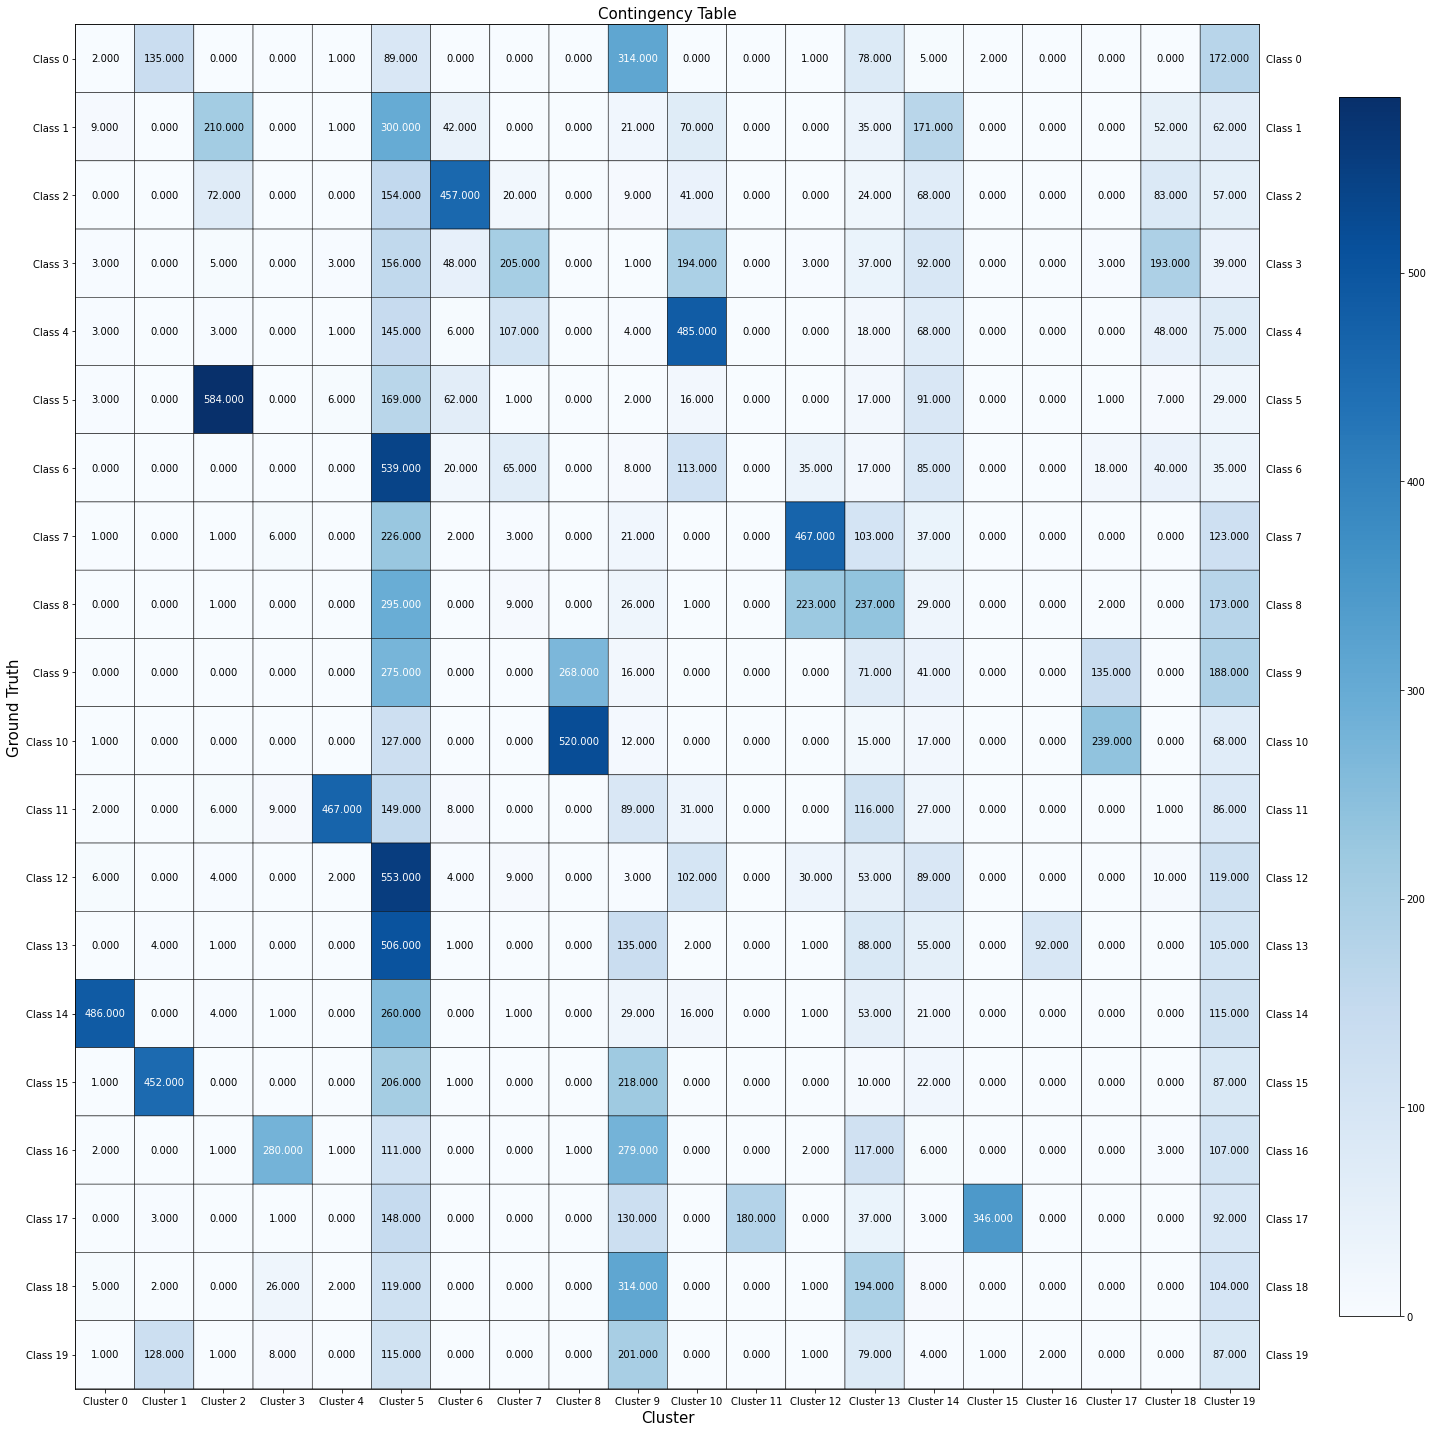

In [23]:

km_nmf20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_nmf20 = km_nmf20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_nmf20 = contingency_matrix(ground_truth, clusters_nmf20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_nmf20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [24]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_nmf20))
print("Completeness:", completeness_score(ground_truth,clusters_nmf20))
print("V-measure:", v_measure_score(ground_truth,clusters_nmf20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_nmf20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_nmf20))

Homogeneity Score: 0.34790859768456994
Completeness: 0.39677714833898997
V-measure: 0.370739421317011
Adjusted RI 0.12210793219608113
Adjusted MI 0.3685640146343022


### SVD

In [25]:
# SVD
svd20 = TruncatedSVD(n_components=300, random_state=0)
X_train_svd20 = svd20.fit_transform(X_train_tfidf20)

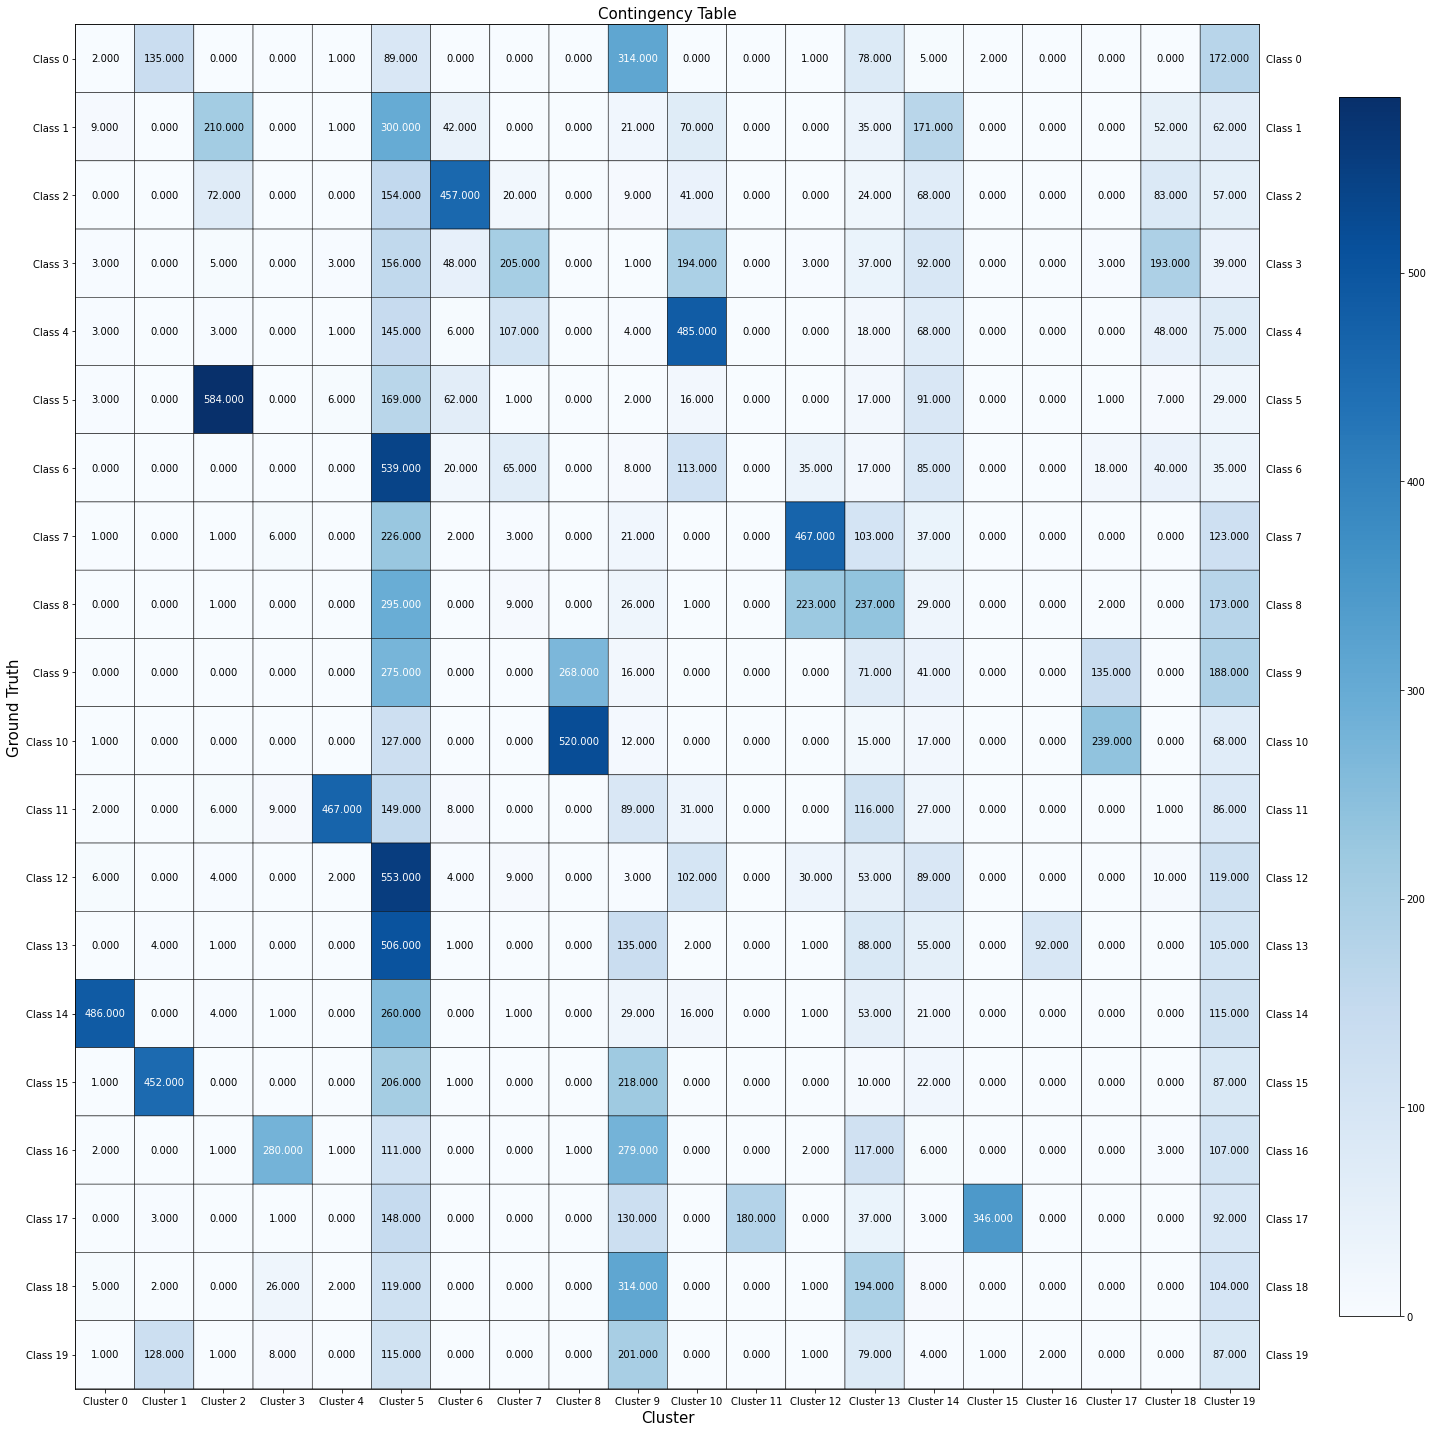

In [26]:
km_svd20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_svd20 = km_svd20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_svd20 = contingency_matrix(ground_truth, clusters_svd20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_svd20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [27]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_svd20))
print("Completeness:", completeness_score(ground_truth,clusters_svd20))
print("V-measure:", v_measure_score(ground_truth,clusters_svd20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_svd20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_svd20))

Homogeneity Score: 0.34790859768456994
Completeness: 0.39677714833898997
V-measure: 0.370739421317011
Adjusted RI 0.12210793219608113
Adjusted MI 0.3685640146343022


### There is a mismatch between cluster labels and class labels. For example, the cluster #3 may correspond to the class #8. As a result, the high-value entries of the 20 × 20 contingency matrix can be scattered around, making it messy to inspect, even if the clustering result is not bad. One can use scipy.optimize.linear_sum_assignment to identify the best-matching cluster-class pairs, and permute the columns of the contingency matrix accordingly. 

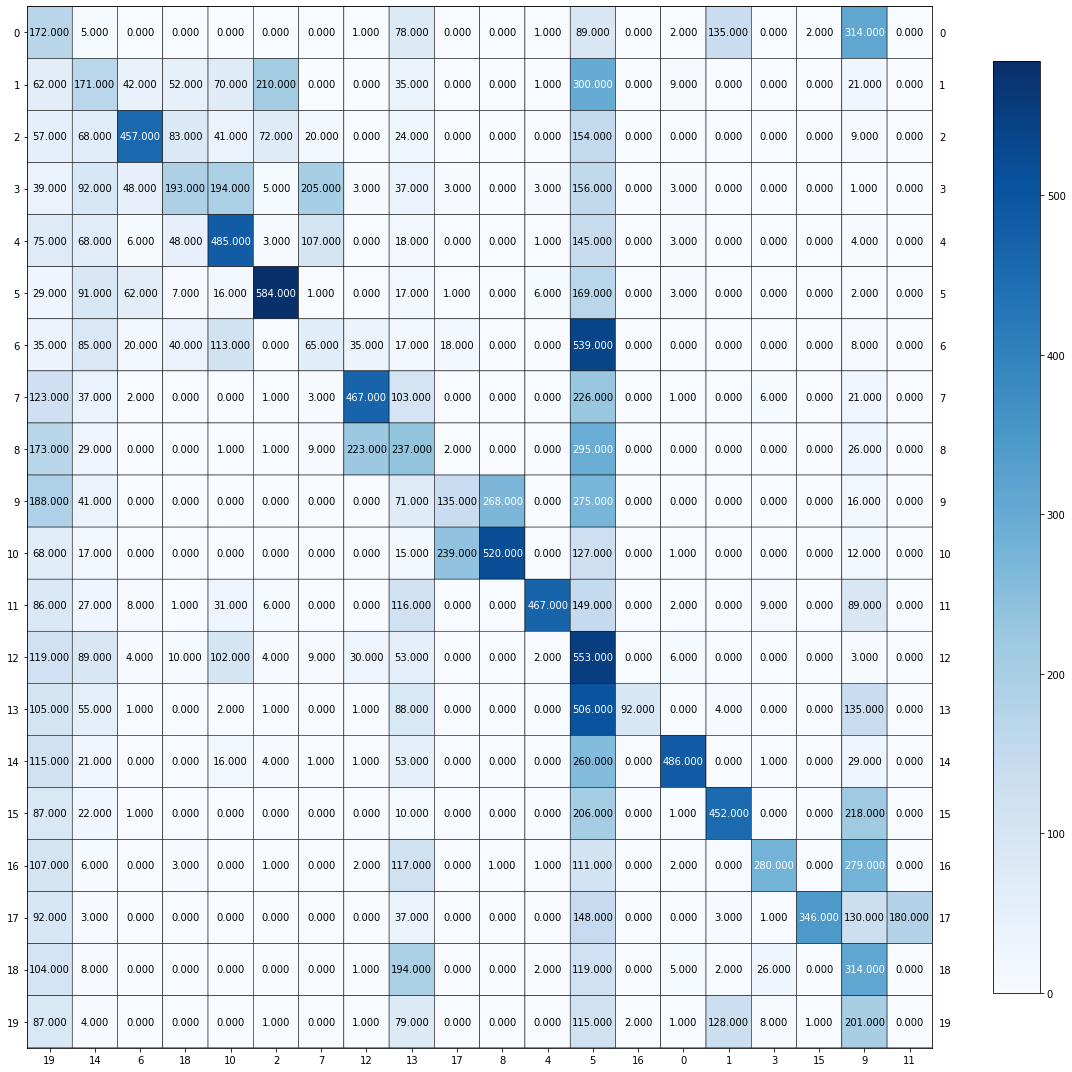

In [28]:
# Contingency Matrix for SVD
cm_svd20 = confusion_matrix(ground_truth, clusters_svd20)
rows, cols = linear_sum_assignment(cm_svd20, maximize = True)
plot_mat(cm_svd20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))

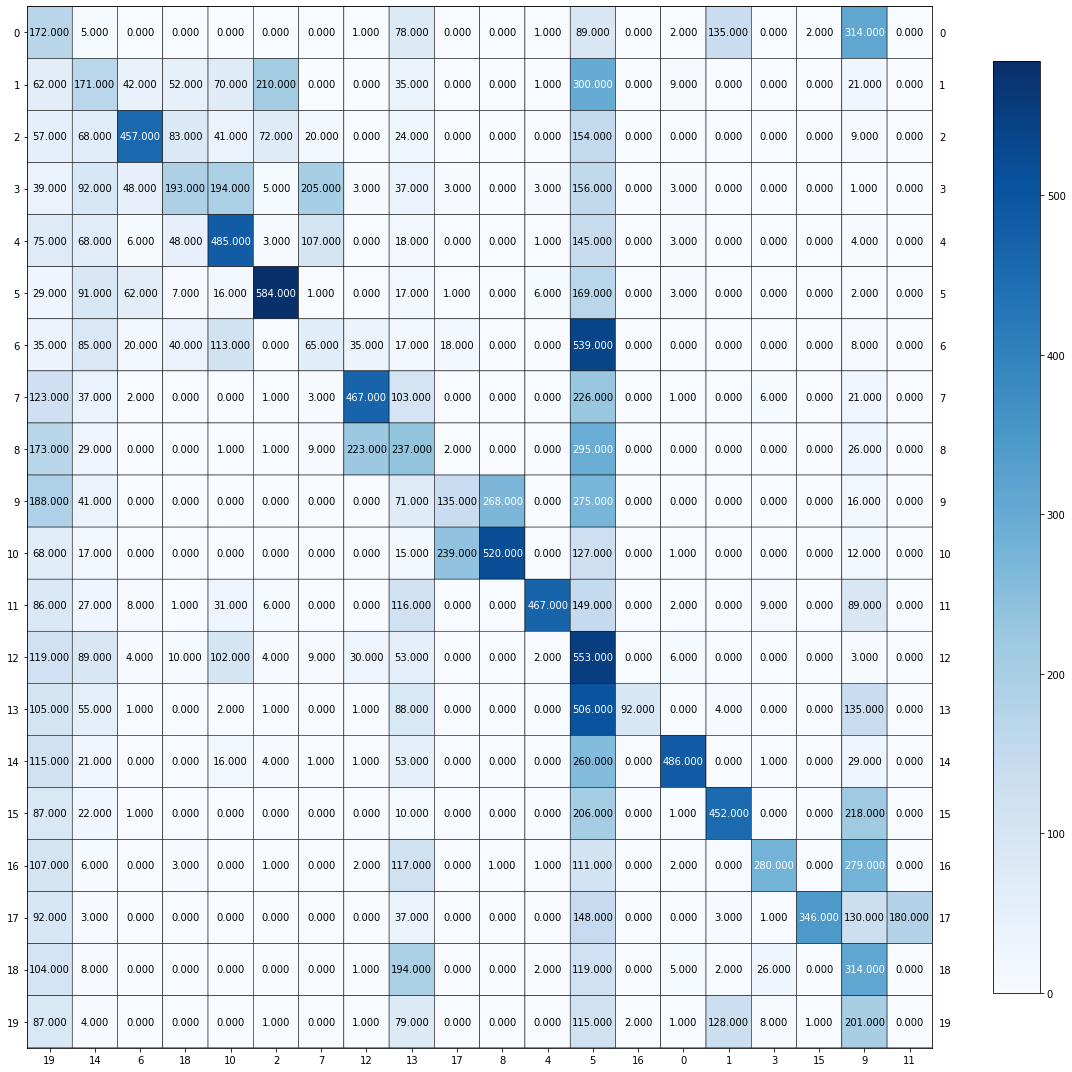

In [29]:
# Contingency Matrix for NMF
cm_nmf20 = confusion_matrix(ground_truth, clusters_nmf20)
rows, cols = linear_sum_assignment(cm_nmf20, maximize = True)
plot_mat(cm_nmf20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))


### QUESTION 11: Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric fails, please look at the FAQ at the end of this spec. Report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations (6 combinations).

In [30]:
eval_scores ={
  'n_components': [],
  'metric': [],
  'h_score': [],
  'c_score': [],
  'v_score': [],
  'adj_rand': [],
  'adj_mutual_info': []
}

In [31]:
def umap_metrics(n_components, metric, title="UMAP"):
  # Dimensionality Reduction using UMAP
  reducer = umap.UMAP(n_components=n_components, metric=metric)
  embedding = reducer.fit_transform(X_train_tfidf20)
  
  # K-means Clustering (k = 20)
  km_umap20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
  clusters_umap20 = km_umap20.fit_predict(embedding)
  
  # Ground truth labels
  ground_truth20 = newsgroups_data20.target
  
  # Visualizing the matrix using plotmat.py
  cm_umap20 = confusion_matrix(ground_truth20, clusters_umap20)
  rows, cols = linear_sum_assignment(cm_umap20, maximize = True)
  plot_mat(cm_umap20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15), title=title)

  # 5 clustering Evaluation Metrics
  h_score = homogeneity_score(ground_truth20, clusters_umap20)
  c_score = completeness_score(ground_truth20,clusters_umap20) 
  v_score = v_measure_score(ground_truth20,clusters_umap20)
  adj_rand = adjusted_rand_score(ground_truth20, clusters_umap20)
  adj_mutual_info = adjusted_mutual_info_score(ground_truth20, clusters_umap20)

  # Prints 5 clustering Evaluation Metrics 
  print("Homogeneity Score:", h_score)
  print("Completeness:", c_score)
  print("V-measure:", v_score)
  print("Adjusted RI", adj_rand)
  print("Adjusted MI", adj_mutual_info)

  # Store Evaluation Measures 
  eval_scores['n_components'].append(n_components)
  eval_scores['metric'].append(metric)
  eval_scores['h_score'].append(h_score)
  eval_scores['c_score'].append(c_score)
  eval_scores['v_score'].append(v_score)
  eval_scores['adj_rand'].append(adj_rand)
  eval_scores['adj_mutual_info'].append(adj_mutual_info)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


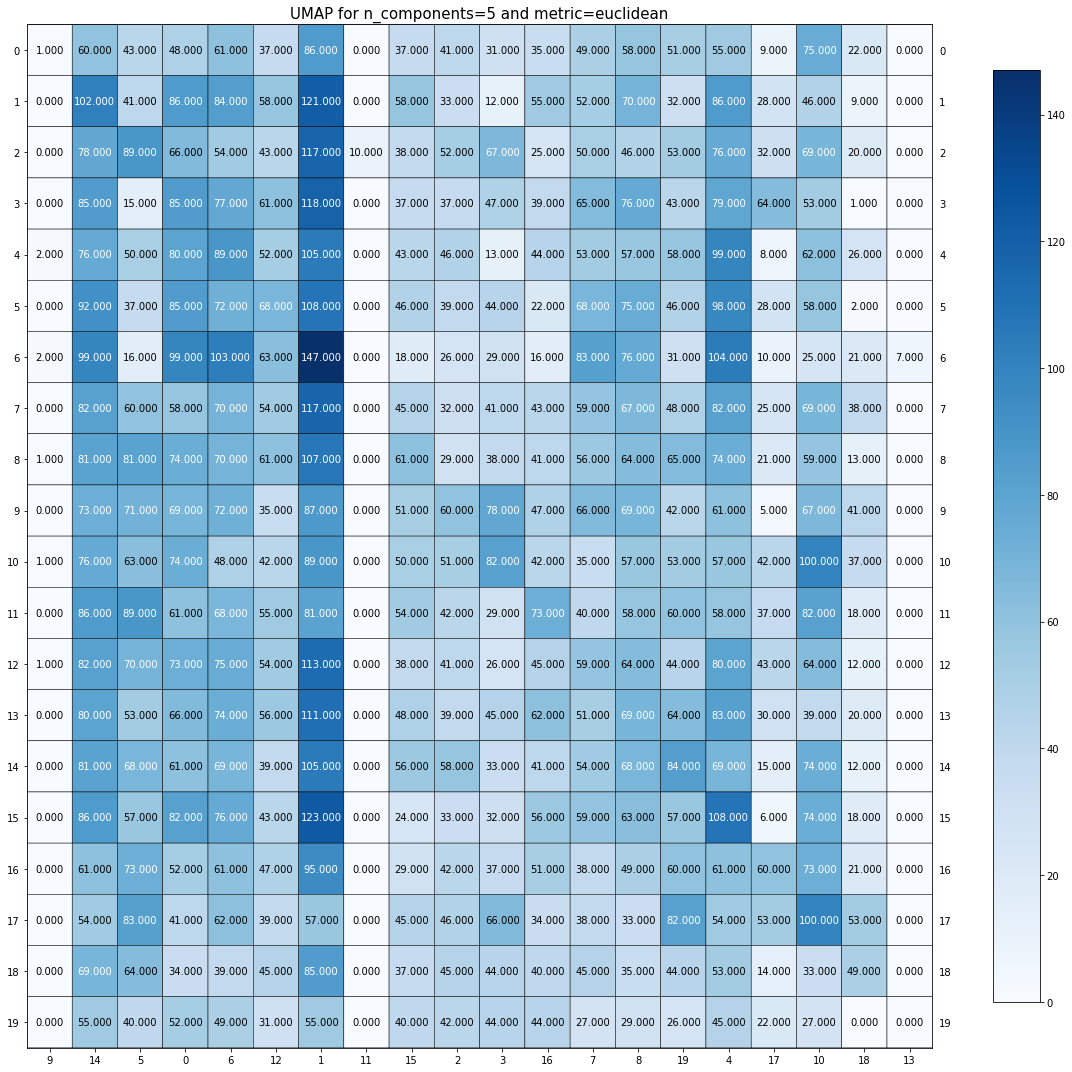

Homogeneity Score: 0.014609091532287627
Completeness: 0.015697714607844103
V-measure: 0.015133851352950665
Adjusted RI 0.002854246075200825
Adjusted MI 0.01186019186673016


In [32]:
umap_metrics(n_components=5, metric="euclidean", title="UMAP for n_components=5 and metric=euclidean")

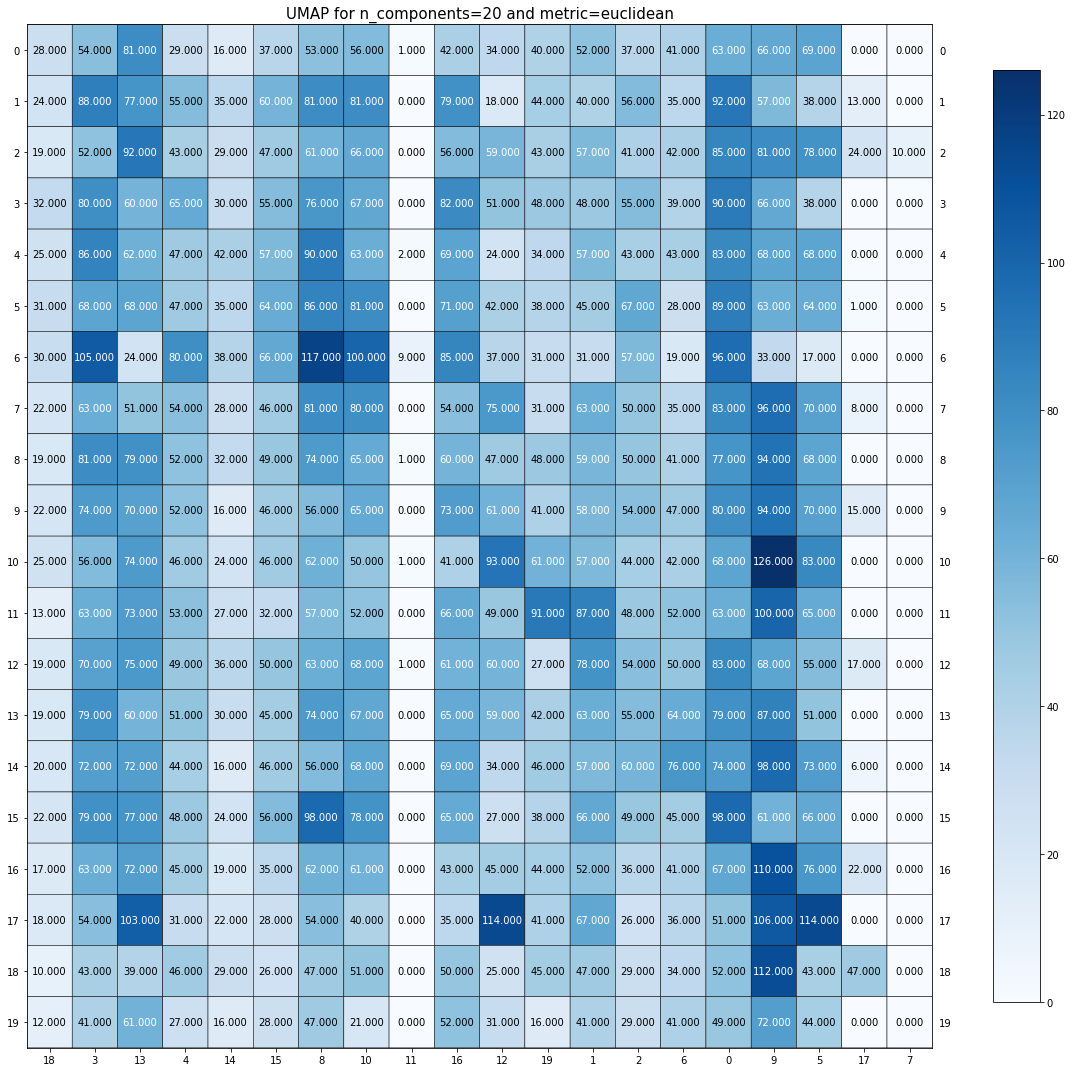

Homogeneity Score: 0.01438639461350556
Completeness: 0.015263170449296865
V-measure: 0.0148118188359035
Adjusted RI 0.002852245486350937
Adjusted MI 0.011509960261788143


In [33]:
umap_metrics(n_components=20, metric="euclidean", title="UMAP for n_components=20 and metric=euclidean")

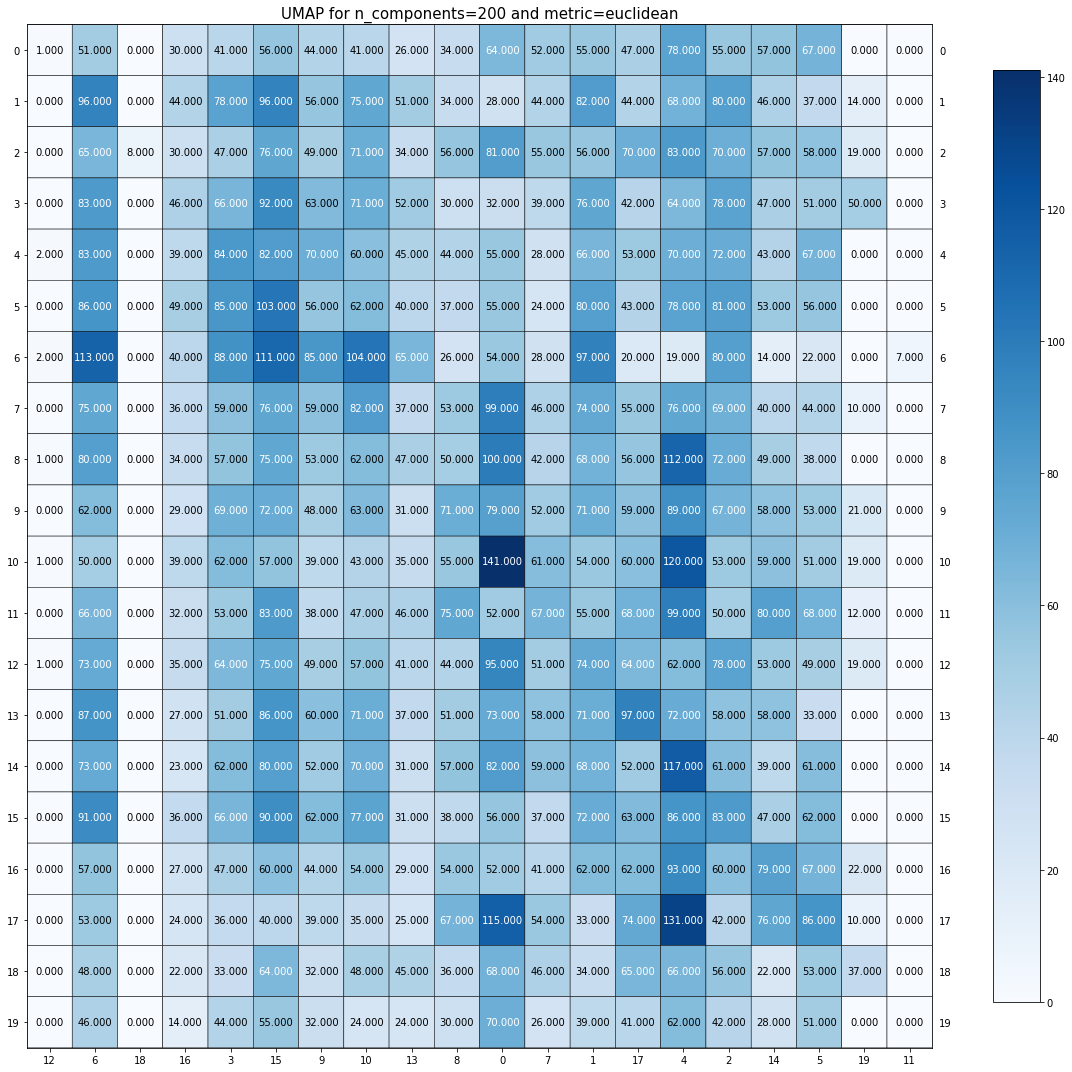

Homogeneity Score: 0.014994957245383243
Completeness: 0.016096460137258108
V-measure: 0.015526196737171455
Adjusted RI 0.0032262725677203517
Adjusted MI 0.0122662482636985


In [34]:
umap_metrics(n_components=200, metric="euclidean", title="UMAP for n_components=200 and metric=euclidean")

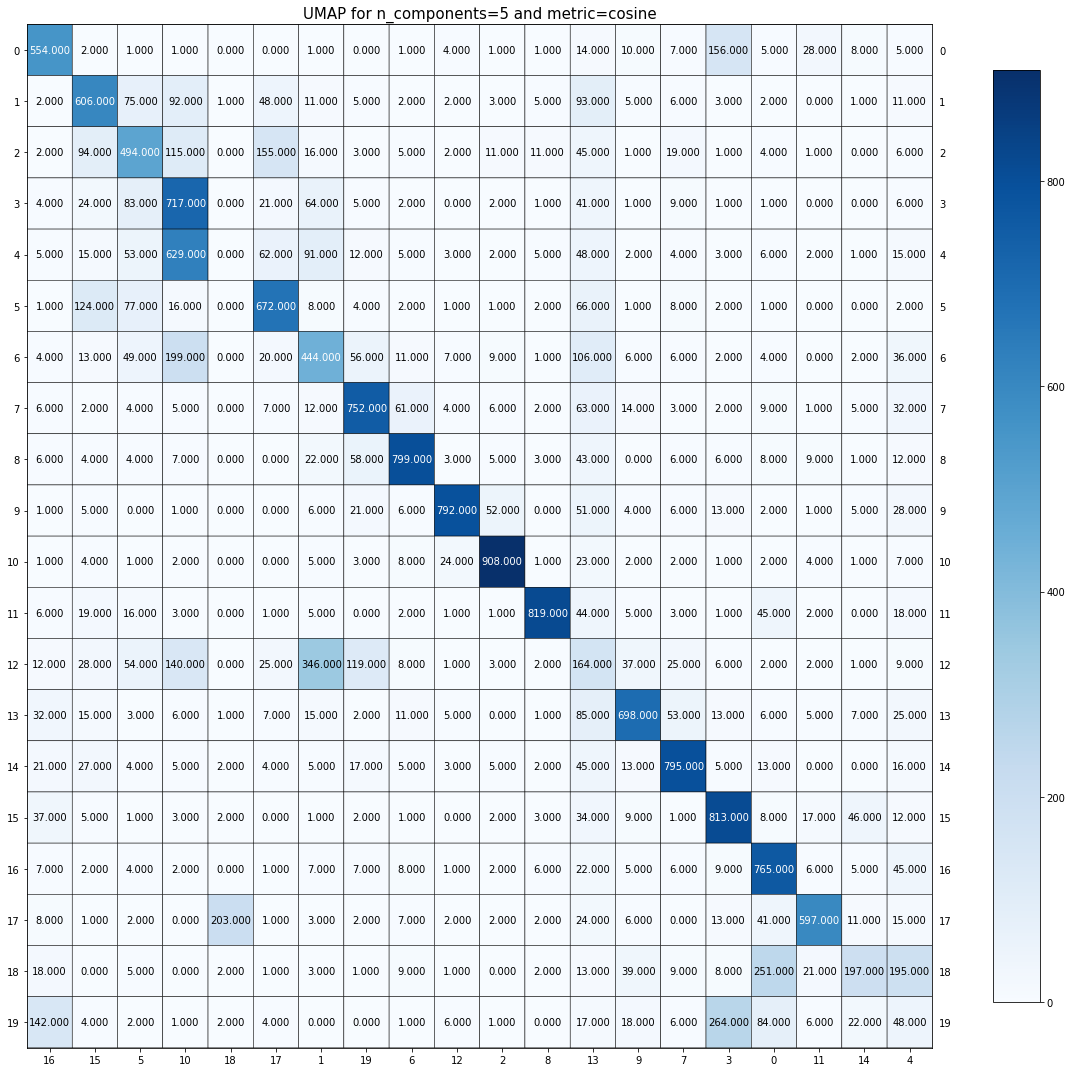

Homogeneity Score: 0.573063131404273
Completeness: 0.5864964429530796
V-measure: 0.5797019757996157
Adjusted RI 0.45613022764649963
Adjusted MI 0.5783286210097325


In [35]:
umap_metrics(n_components=5, metric="cosine", title="UMAP for n_components=5 and metric=cosine")

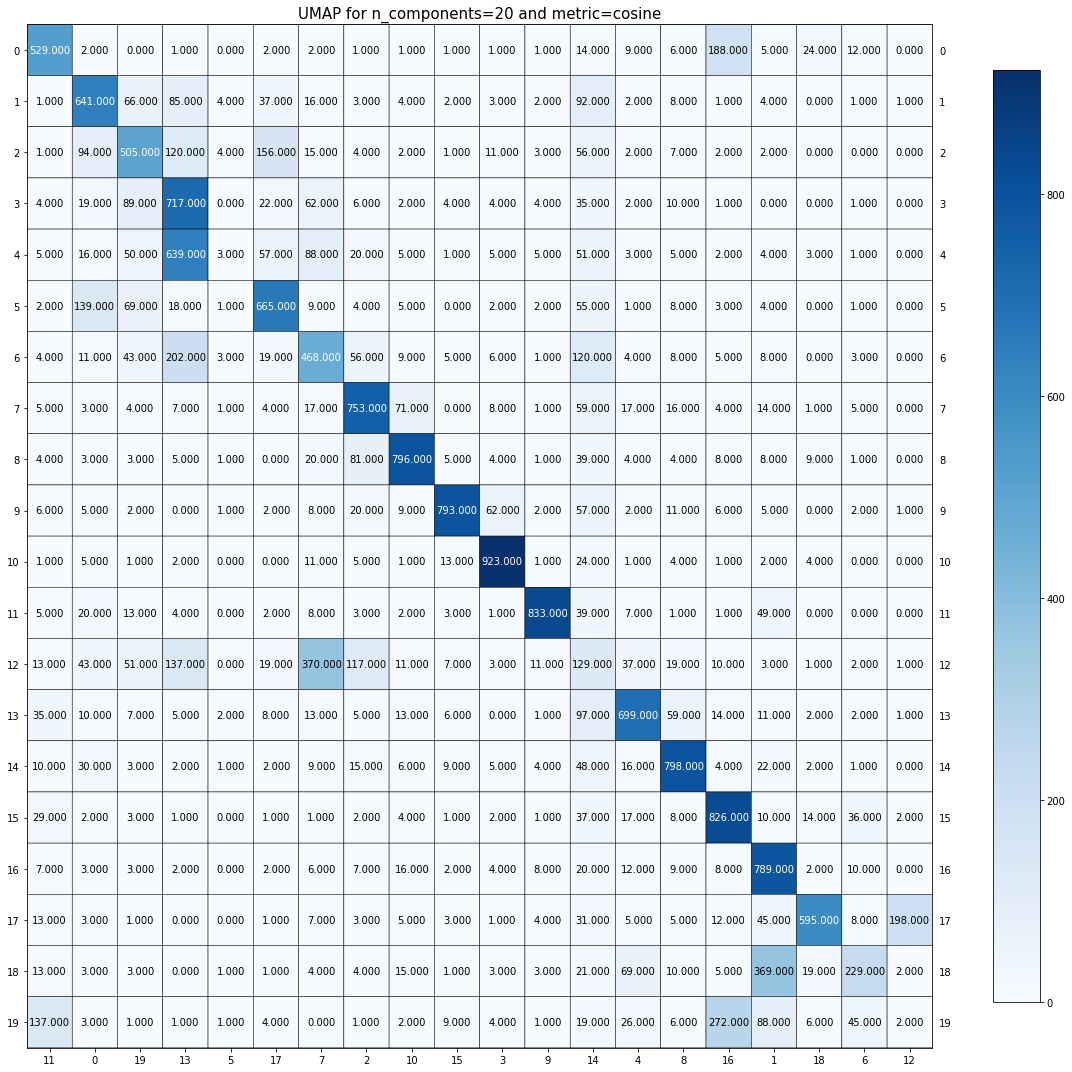

Homogeneity Score: 0.5722950878574007
Completeness: 0.5944802999251327
V-measure: 0.5831767777030937
Adjusted RI 0.4567080871600432
Adjusted MI 0.5817930960251217


In [36]:
umap_metrics(n_components=20, metric="cosine", title="UMAP for n_components=20 and metric=cosine")

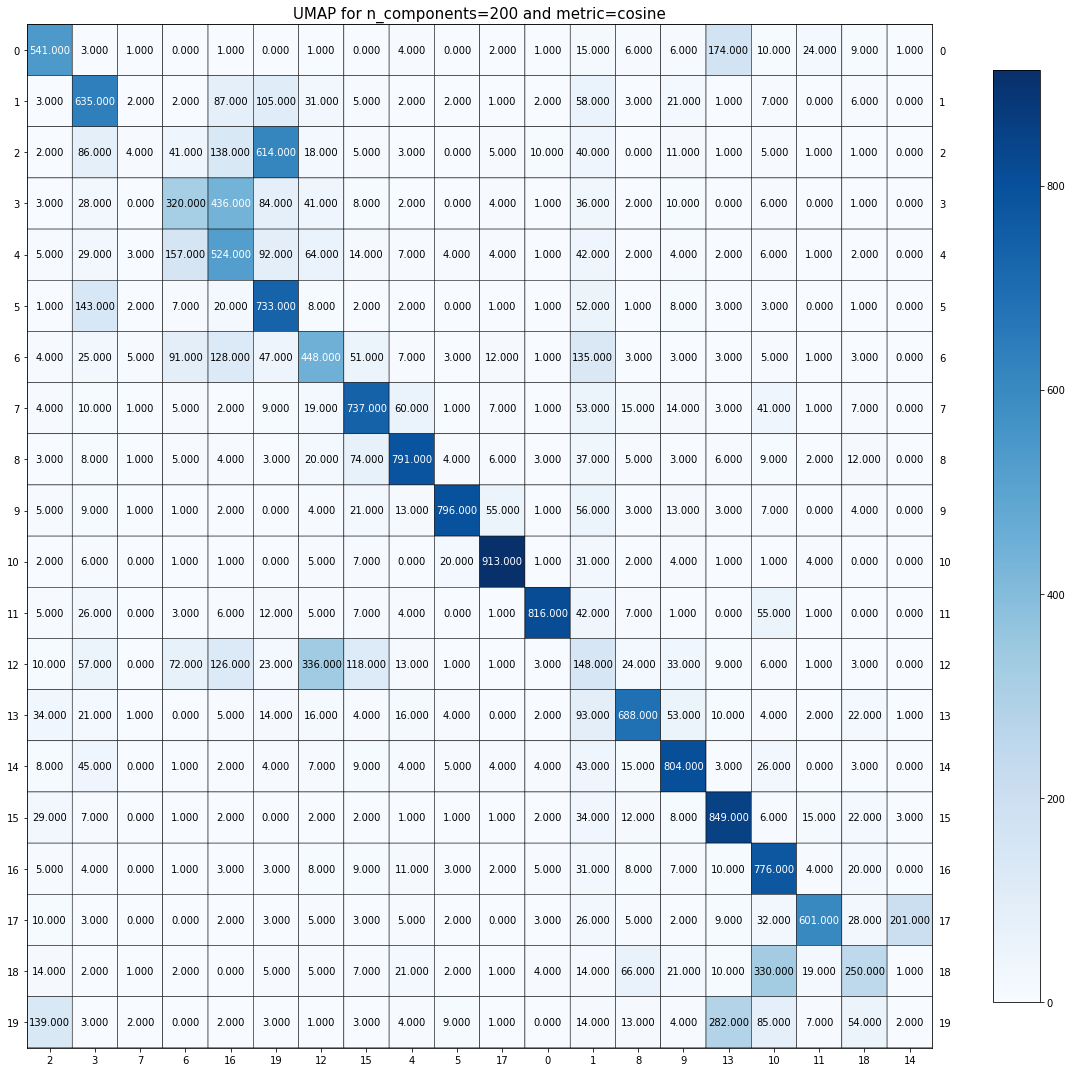

Homogeneity Score: 0.564586981277977
Completeness: 0.5858709972477733
V-measure: 0.5750321070888809
Adjusted RI 0.44453666969983924
Adjusted MI 0.573622118041904


In [37]:
umap_metrics(n_components=200, metric="cosine", title="UMAP for n_components=200 and metric=cosine")

### QUESTION 12: Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?

The UMAP setting with **n_components = 200 and metric = cosine** works best in terms of the contingency matrix as well as the 5 evaluation measures compared to the rest of the combinations. This is because setting a higher number of components allows UMAP to better capture complex patterns within the data leading to better clustering. The Cosine similarity metric is better in comparison to Euclidean distance as it is ideal for high-dimensional/ sparse data where curse of dimensionality can affect the results. Euclidean is better equipped for data that exhibit linear relationships. 

In [38]:
for i in range(0,6):
  print(eval_scores['n_components'][i])
  print(eval_scores['metric'][i])
  print(eval_scores['h_score'][i])
  print(eval_scores['c_score'][i])
  print(eval_scores['v_score'][i])
  print(eval_scores['adj_rand'][i])
  print(eval_scores['adj_mutual_info'][i])

5
euclidean
0.014609091532287627
0.015697714607844103
0.015133851352950665
0.002854246075200825
0.01186019186673016
20
euclidean
0.01438639461350556
0.015263170449296865
0.0148118188359035
0.002852245486350937
0.011509960261788143
200
euclidean
0.014994957245383243
0.016096460137258108
0.015526196737171455
0.0032262725677203517
0.0122662482636985
5
cosine
0.573063131404273
0.5864964429530796
0.5797019757996157
0.45613022764649963
0.5783286210097325
20
cosine
0.5722950878574007
0.5944802999251327
0.5831767777030937
0.4567080871600432
0.5817930960251217
200
cosine
0.564586981277977
0.5858709972477733
0.5750321070888809
0.44453666969983924
0.573622118041904


### QUESTION 13: So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.

On comparing the 5 evaluation metrics for K-means clustering the UMAP reduced data with the setting n_components = 200 and metric = cosine gave the best results for K-means clustering among the 4 different representation learning techniques. 

### QUESTION 14: Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single” linkage criteria. Report the five clustering evaluation metrics for each case.

The Agglomerative performance of ward linkage was better than single linkage criteria on comparing the 5 clustering evaluation metrics. 

In [39]:
# Dimensionality Reduction using UMAP 
reducer20 = umap.UMAP(n_components=200, metric="cosine")
embedding20 = reducer20.fit_transform(X_train_tfidf20)

# Ground truth labels
ground_truth20 = newsgroups_data20.target

###  Agglomerative Clustering (Ward)

In [40]:
# Agglomerative Clustering for ward algorithm 

ward = AgglomerativeClustering(n_clusters = 20, affinity ="euclidean", linkage="ward")
ward.fit(embedding20)
ward_labels = ward.labels_ 

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [41]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, ward_labels)
c_score = completeness_score(ground_truth20,ward_labels) 
v_score = v_measure_score(ground_truth20,ward_labels)
adj_rand = adjusted_rand_score(ground_truth20, ward_labels)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, ward_labels)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.5657747385780165
Completeness: 0.5875369073722306
V-measure: 0.5764505046674958
Adjusted RI 0.43768097994417804
Adjusted MI 0.5750449287480054


###  Agglomerative Clustering (Single Linkage Criteria)

In [42]:
# Agglomerative Clustering for (Single Linkage Criteria) 

single = AgglomerativeClustering(n_clusters = 20, affinity ="euclidean", linkage="single")
single.fit(embedding20)
single_labels = single.labels_ 

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [43]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, single_labels)
c_score = completeness_score(ground_truth20,single_labels) 
v_score = v_measure_score(ground_truth20,single_labels)
adj_rand = adjusted_rand_score(ground_truth20, single_labels)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, single_labels)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.01695239351921457
Completeness: 0.36823784187459485
V-measure: 0.03241262228645149
Adjusted RI 0.00046796298443246403
Adjusted MI 0.02770166493579416


## Question 15: 

### 15.1 Apply HDBSCAN on UMAP-transformed 20-category data. Use min_cluster_size=100.

In [44]:
# Dimensionality Reduction using UMAP 
reducer20 = umap.UMAP(n_components=200, metric="cosine")
embedding20 = reducer20.fit_transform(X_train_tfidf20)

# Ground truth labels
ground_truth20 = newsgroups_data20.target

# HDBSCAN model
min_cluster_size = 100
hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size)
hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

In [45]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, hdbscan_cluster)
c_score = completeness_score(ground_truth20,hdbscan_cluster) 
v_score = v_measure_score(ground_truth20,hdbscan_cluster)
adj_rand = adjusted_rand_score(ground_truth20, hdbscan_cluster)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, hdbscan_cluster)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.4190806671652832
Completeness: 0.6166314252622905
V-measure: 0.49901572258039667
Adjusted RI 0.20196227347874798
Adjusted MI 0.4977949782155543


### 15.2 Vary the min cluster size among 20, 100, 200 and report your findings in terms of the five clustering evaluation metrics - you will plot the best contingency matrix in the next question. Feel free to try modifying other parameters in HDBSCAN to get better performance.

In [46]:
min_cluster_sizes = [20, 100, 200]

for cluster_size in min_cluster_sizes:
    # Dimensionality Reduction using UMAP 
    reducer20 = umap.UMAP(n_components=200, metric="cosine")
    embedding20 = reducer20.fit_transform(X_train_tfidf20)

    # Ground truth labels
    ground_truth20 = newsgroups_data20.target

    # HDBSCAN model
    hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = cluster_size)
    hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

    # 5 clustering Evaluation Metrics
    h_score = homogeneity_score(ground_truth20, hdbscan_cluster)
    c_score = completeness_score(ground_truth20,hdbscan_cluster) 
    v_score = v_measure_score(ground_truth20,hdbscan_cluster)
    adj_rand = adjusted_rand_score(ground_truth20, hdbscan_cluster)
    adj_mutual_info = adjusted_mutual_info_score(ground_truth20, hdbscan_cluster)

    # Prints 5 clustering Evaluation Metrics for each min_cluster_size
    print("-"*20 + f" HDBSCAN clustering with min_cluster_size={cluster_size} " + "-"*20)
    print("Homogeneity Score:", h_score)
    print("Completeness:", c_score)
    print("V-measure:", v_score)
    print("Adjusted RI", adj_rand)
    print("Adjusted MI", adj_mutual_info)

-------------------- HDBSCAN clustering with min_cluster_size=20 --------------------
Homogeneity Score: 0.4162914667318007
Completeness: 0.43305407272219654
V-measure: 0.4245073570966044
Adjusted RI 0.06390645681972563
Adjusted MI 0.41092792978375625
-------------------- HDBSCAN clustering with min_cluster_size=100 --------------------
Homogeneity Score: 0.42267329012263655
Completeness: 0.6179261319474856
V-measure: 0.5019815804306648
Adjusted RI 0.22145540038735279
Adjusted MI 0.5009773908638369
-------------------- HDBSCAN clustering with min_cluster_size=200 --------------------
Homogeneity Score: 0.4110517095808222
Completeness: 0.6042128469358168
V-measure: 0.4892571538905934
Adjusted RI 0.20558464620370817
Adjusted MI 0.48822498303646295


## Question 16

### 16.1 Plot the contingency matrix for the best clustering model from Question 15.

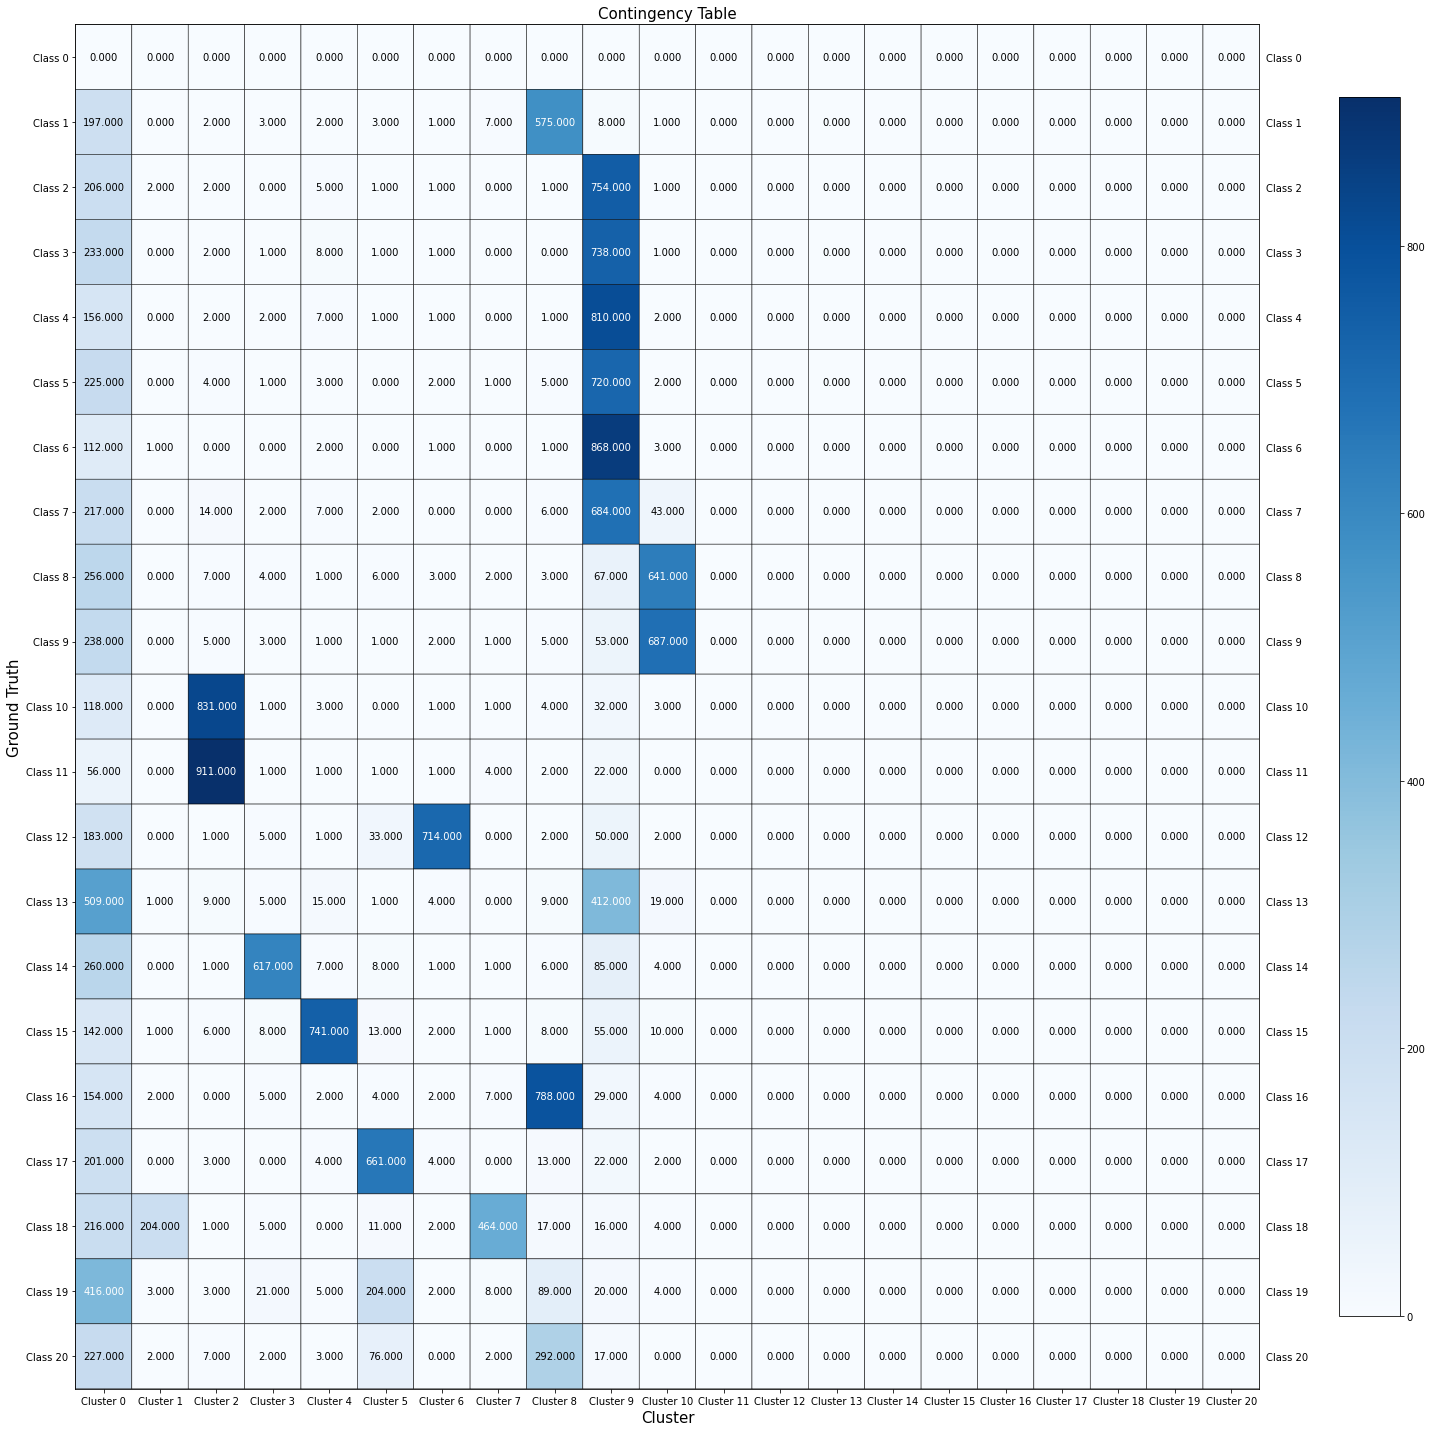

In [48]:
# Ground truth labels
ground_truth20 = newsgroups_data20.target

# Best HDBSCAN model
best_min_cluster_size = 100
best_hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = best_min_cluster_size)
best_hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

mat_hdbscan20 = confusion_matrix(ground_truth20, best_hdbscan_cluster)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,21)]
ylabels = [f'Class {i}'.format(i) for i in range(0,21)]
plotmat.plot_mat(mat_hdbscan20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

### 16.2 How many clusters are given by the model?

In [ ]:
negative_clusters = hdbscan_cluster.count(-1)

total_hdbscan_clusters = len(set(best_hdbscan_cluster)) - negative_clusters

print("Number of clusters given by the model: ", total_hdbscan_clusters)

### 16.3 What does “-1” mean for the clustering labels?

Clusters that are labeled -1 represent points that are considered as outliers or noise by the HDBSCAN model

### 16.4 Interpret the contingency matrix considering the answer to these questions.

### 5.2 Report a good choice of r for SVD and NMF respectively.

According to the graphs, the best rank for SVD is 20 and the best rank for NMF is 2.

## Question 6

### 6.1 How do you explain the non-monotonic behavior of the measures as r increases?

*incomplete*

## Question 7

### 7.1 Are these measures on average better than those computed in Question 3?

*incomplete*

## Question 8

### 8.1 Visualize the clustering results for SVD with your optimal choice of r for K-Means clustering

Text(0.5, 1.0, 'Ground Truth K-Means clustering (SVD)')

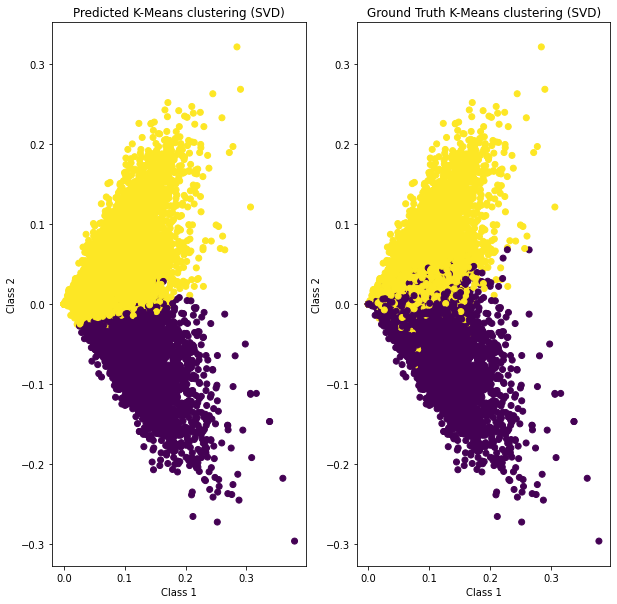

In [18]:
# Optimal choice of r
opt_r_svd = 20

# SVD
svd = TruncatedSVD(n_components=opt_r_svd, random_state=0)
X_train_svd = svd.fit_transform(X_train_tfidf)

# K-Means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
svd_cluster = km.fit_predict(X_train_svd)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=svd_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (SVD)')

plt.subplot(122)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (SVD)')

### 8.2 Visualize the clustering results for NMF with your choice of r for K-Means clustering.

Text(0.5, 1.0, 'Ground Truth K-Means clustering (NMF)')

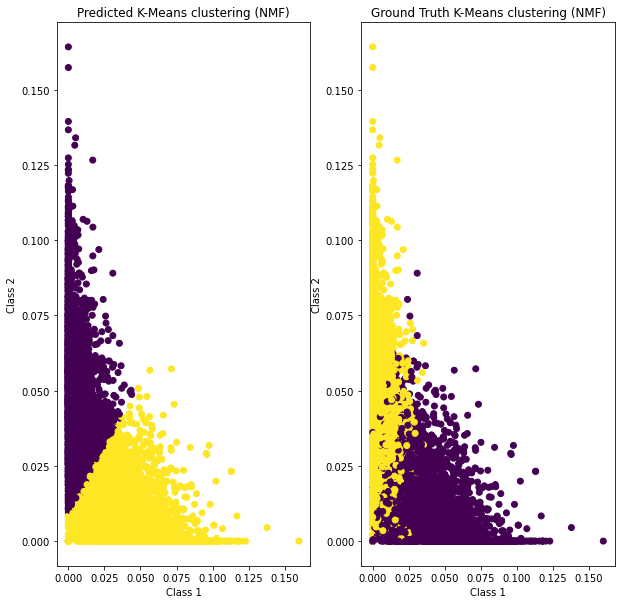

In [19]:
# Optimal choice of r
opt_r_nmf = 2

# NMF
nmf = NMF(n_components=opt_r_nmf, random_state=0, max_iter=2000)
X_train_nmf = nmf.fit_transform(X_train_tfidf)

# K-means
km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
nmf_cluster = km.fit_predict(X_train_nmf)

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=nmf_cluster, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Predicted K-Means clustering (NMF)')

plt.subplot(122)
plt.scatter(X_train_nmf[:, 0], X_train_nmf[:, 1], c=ground_truth, cmap='viridis')
plt.xlabel("Class 1")
plt.ylabel("Class 2")
plt.title('Ground Truth K-Means clustering (NMF)')

## Question 9

### 9.1 What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

#### QUESTION 10: Load documents with the same configuration as in Question 1, but for ALL 20 categories. Construct the TF-IDF matrix, reduce its dimensionality using BOTH NMF and SVD (specify settings you choose and why), and perform K-Means clustering with k=20 . Visualize the contingency matrix and report the five clustering metrics (DO BOTH NMF AND SVD).

- The dimensions of the TF-IDF matrix is (18846, 45365)
- From Q5 we got optimal value of r as 2 for NMF and 300 for SVD therefore these values of r will be used for NMF and SVD respectively 

In [20]:
# Load the dataset
newsgroups_data20 = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers'), random_state=42)

In [21]:
# TF-IDF Vectorizer
tfidf_vect20 = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf20 = tfidf_vect20.fit_transform(newsgroups_data20.data)

print("Dimensions of the TD-IDF matrix: ", X_train_tfidf20.shape)

Dimensions of the TD-IDF matrix:  (18846, 45365)


### NMF

In [22]:
# NMF
nmf20 = NMF(n_components=2, random_state=0, max_iter=2000)
X_train_nmf20 = nmf20.fit_transform(X_train_tfidf20)

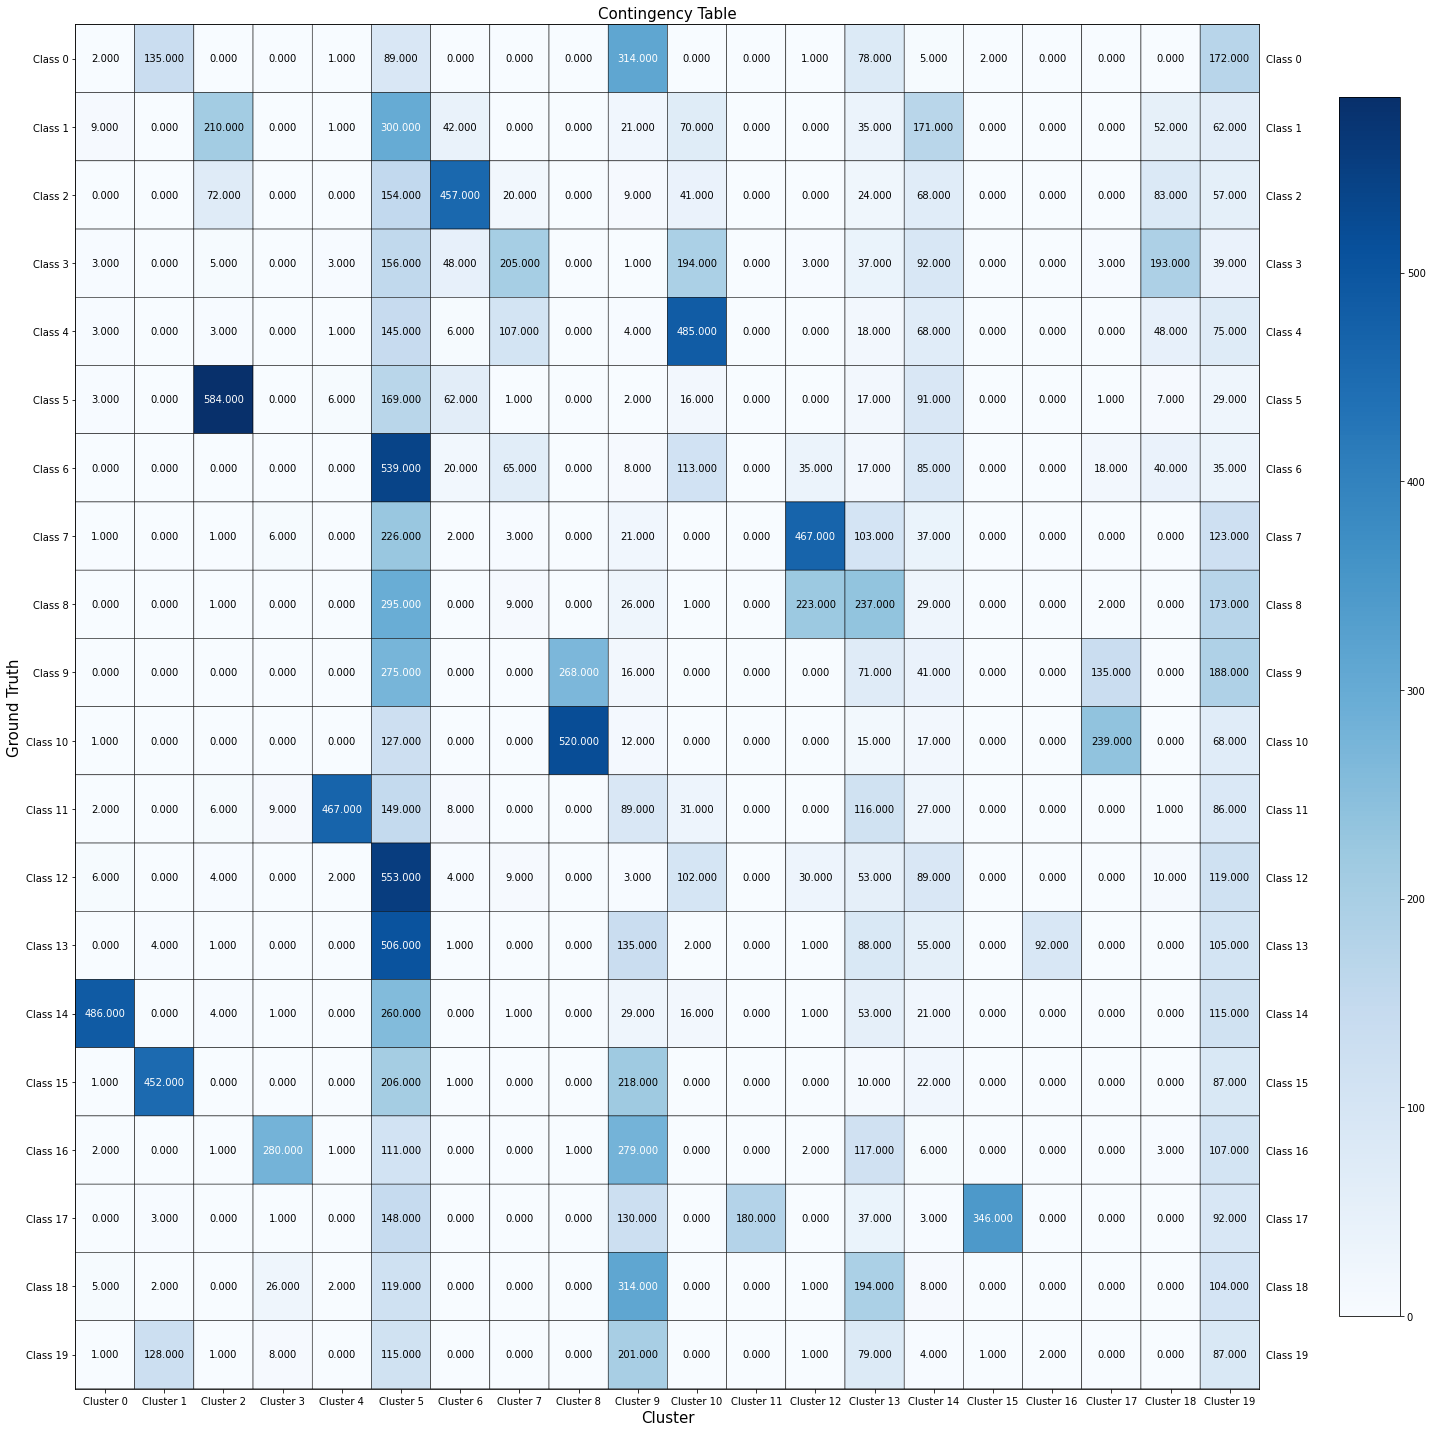

In [23]:

km_nmf20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_nmf20 = km_nmf20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_nmf20 = contingency_matrix(ground_truth, clusters_nmf20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_nmf20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [24]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_nmf20))
print("Completeness:", completeness_score(ground_truth,clusters_nmf20))
print("V-measure:", v_measure_score(ground_truth,clusters_nmf20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_nmf20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_nmf20))

Homogeneity Score: 0.34790859768456994
Completeness: 0.39677714833898997
V-measure: 0.370739421317011
Adjusted RI 0.12210793219608113
Adjusted MI 0.3685640146343022


### SVD

In [25]:
# SVD
svd20 = TruncatedSVD(n_components=300, random_state=0)
X_train_svd20 = svd20.fit_transform(X_train_tfidf20)

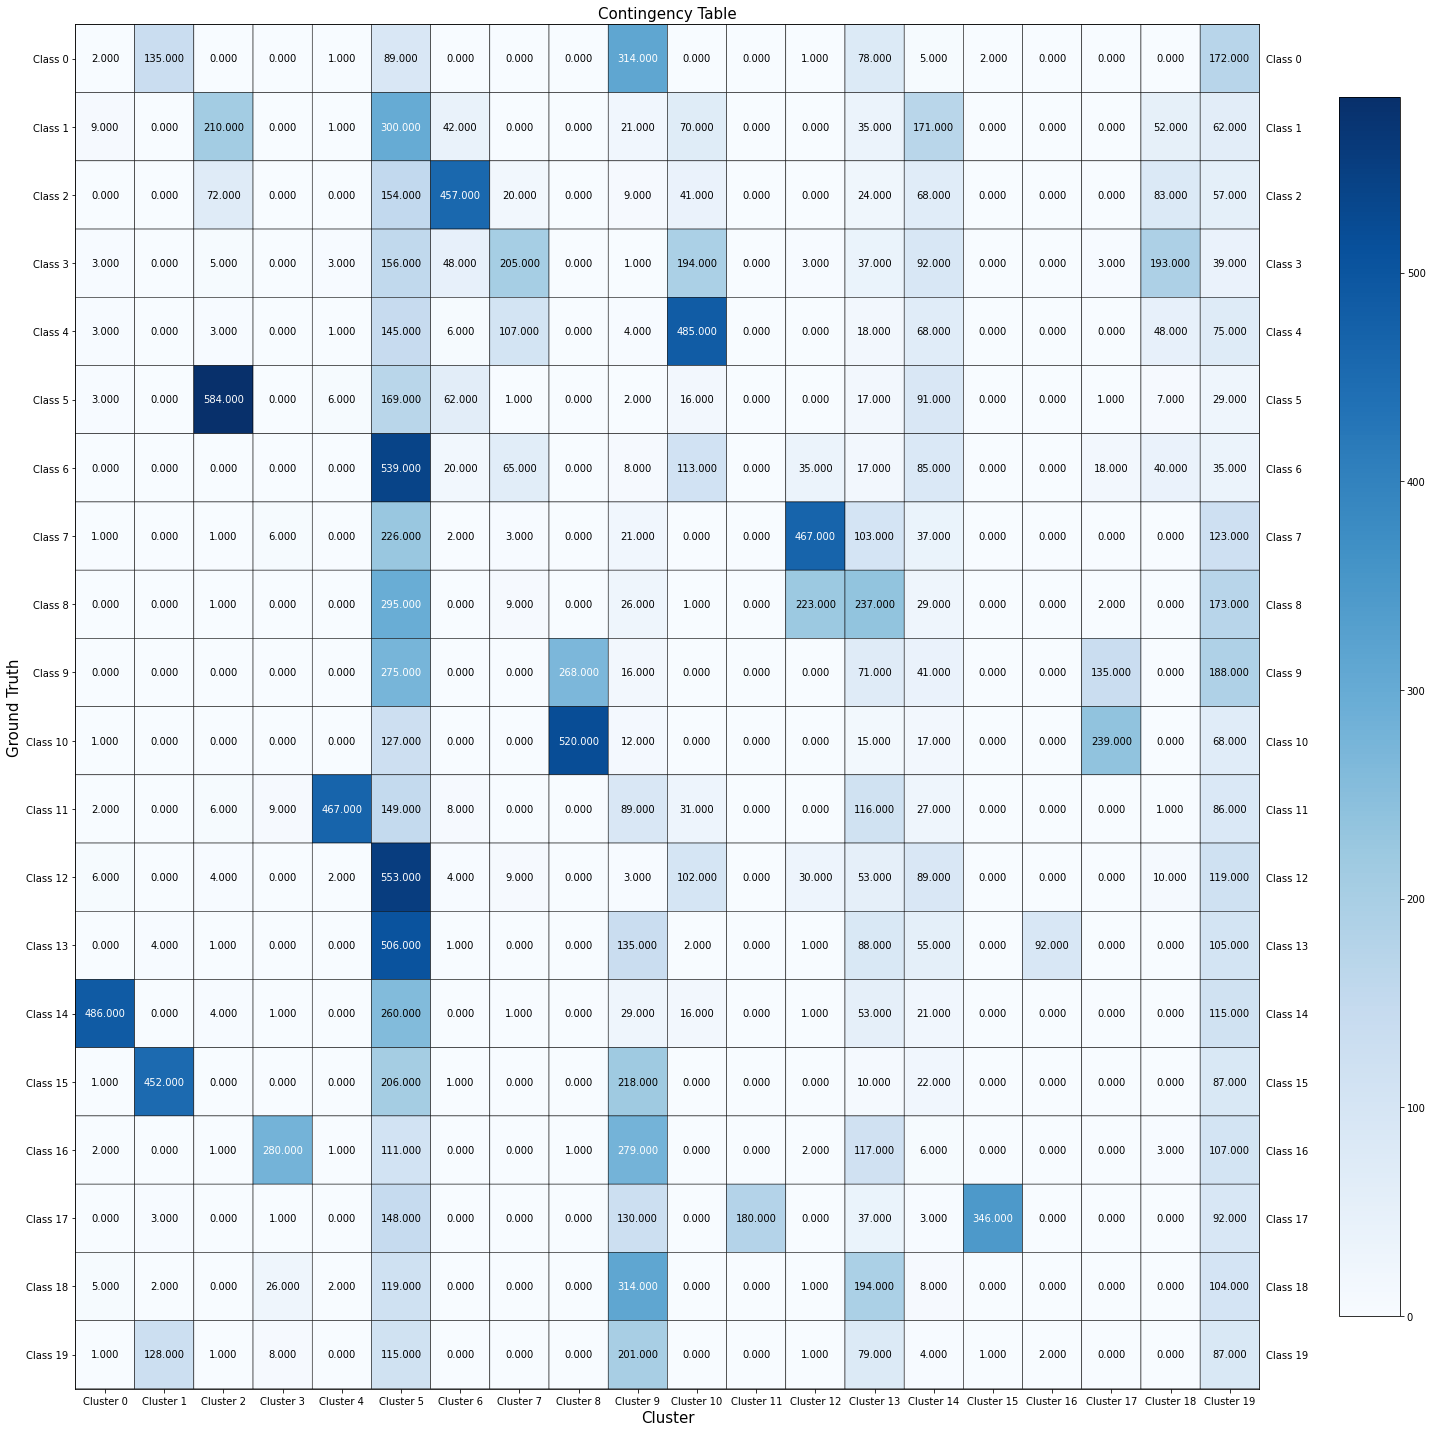

In [26]:
km_svd20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
clusters_svd20 = km_svd20.fit_predict(X_train_tfidf20)

# Ground truth labels
ground_truth = newsgroups_data20.target

mat_svd20 = contingency_matrix(ground_truth, clusters_svd20)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,20)]
ylabels = [f'Class {i}'.format(i) for i in range(0,20)]
plotmat.plot_mat(mat_svd20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

In [27]:
print("Homogeneity Score:", homogeneity_score(ground_truth, clusters_svd20))
print("Completeness:", completeness_score(ground_truth,clusters_svd20))
print("V-measure:", v_measure_score(ground_truth,clusters_svd20))
print("Adjusted RI", adjusted_rand_score(ground_truth, clusters_svd20))
print("Adjusted MI", adjusted_mutual_info_score(ground_truth, clusters_svd20))

Homogeneity Score: 0.34790859768456994
Completeness: 0.39677714833898997
V-measure: 0.370739421317011
Adjusted RI 0.12210793219608113
Adjusted MI 0.3685640146343022


### There is a mismatch between cluster labels and class labels. For example, the cluster #3 may correspond to the class #8. As a result, the high-value entries of the 20 × 20 contingency matrix can be scattered around, making it messy to inspect, even if the clustering result is not bad. One can use scipy.optimize.linear_sum_assignment to identify the best-matching cluster-class pairs, and permute the columns of the contingency matrix accordingly. 

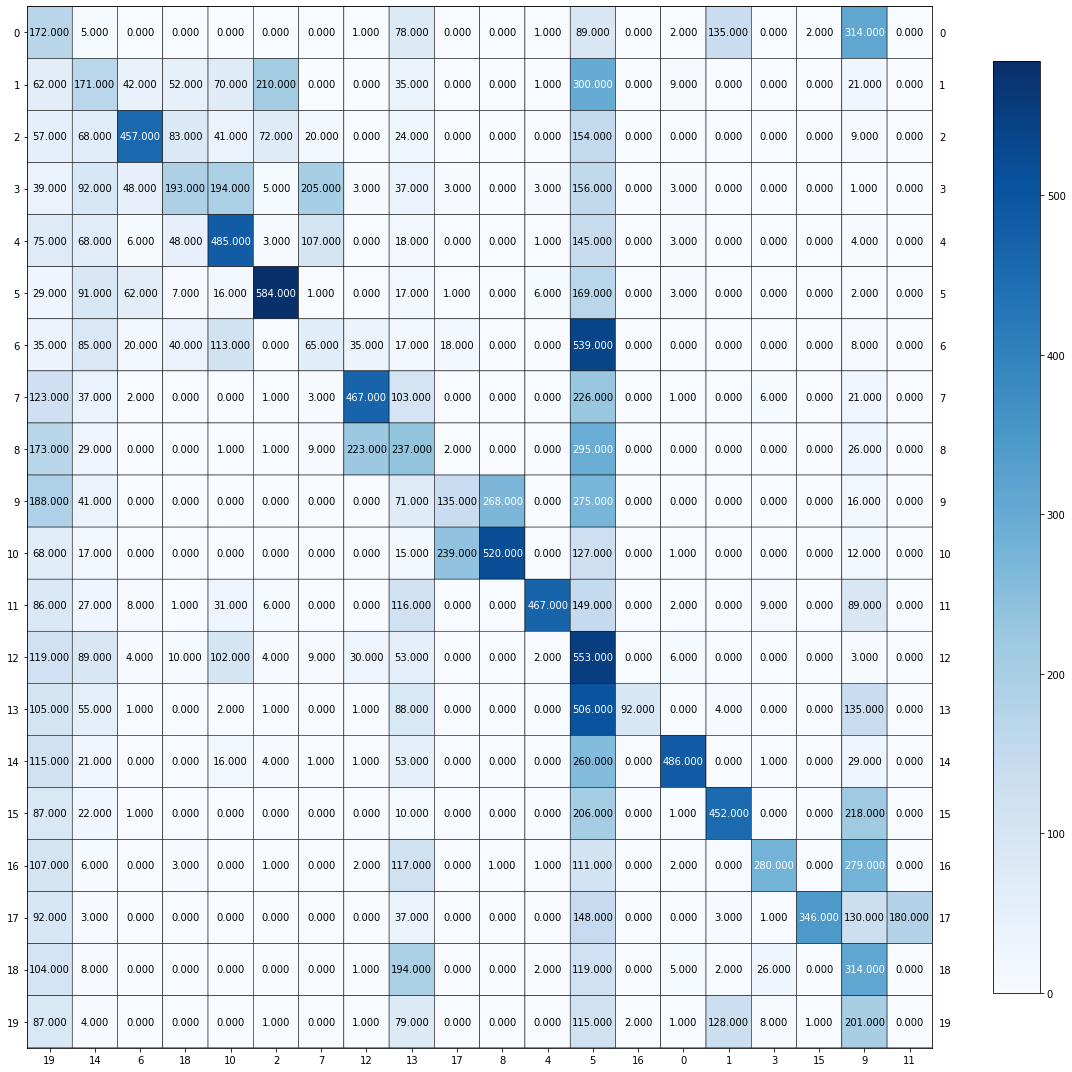

In [28]:
# Contingency Matrix for SVD
cm_svd20 = confusion_matrix(ground_truth, clusters_svd20)
rows, cols = linear_sum_assignment(cm_svd20, maximize = True)
plot_mat(cm_svd20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))

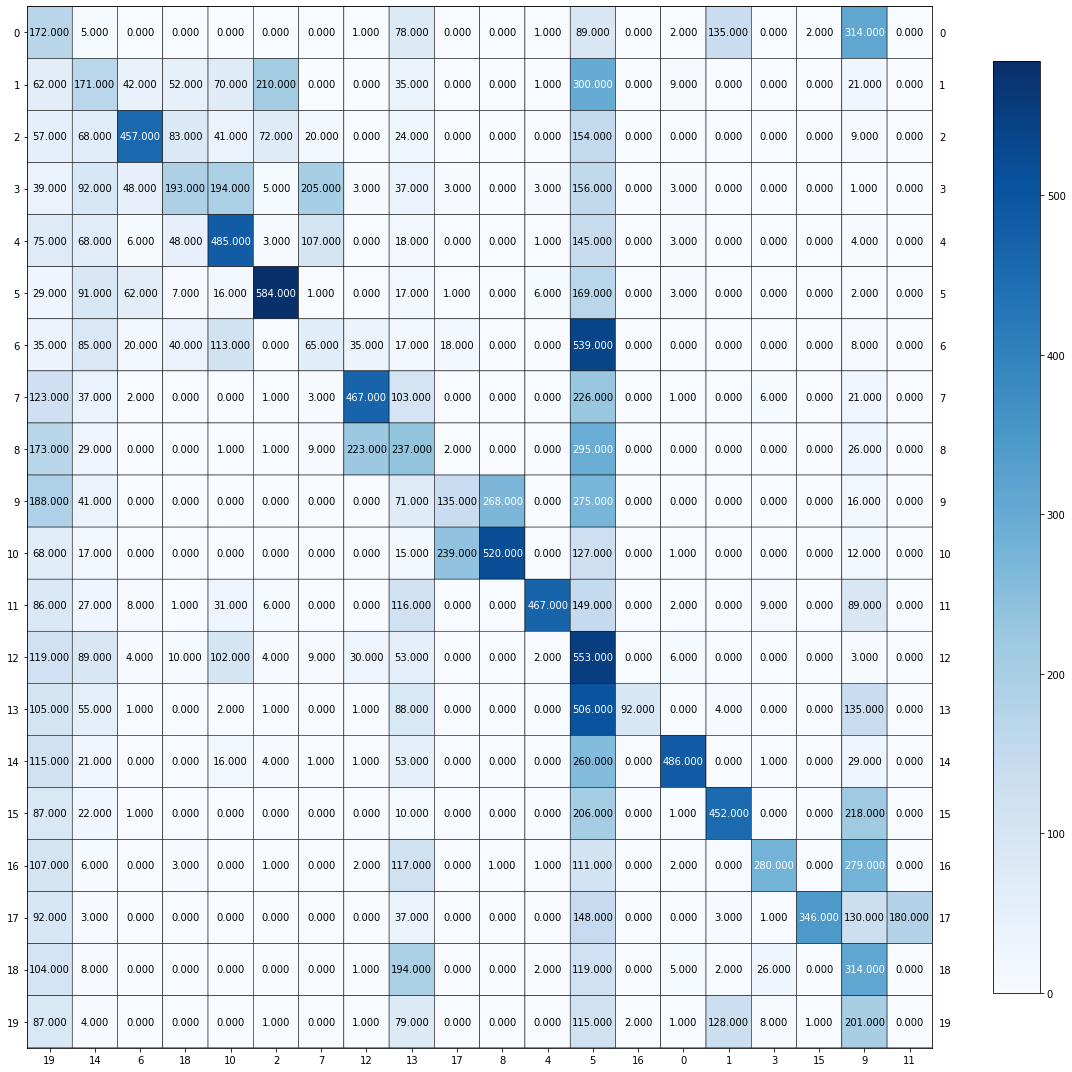

In [29]:
# Contingency Matrix for NMF
cm_nmf20 = confusion_matrix(ground_truth, clusters_nmf20)
rows, cols = linear_sum_assignment(cm_nmf20, maximize = True)
plot_mat(cm_nmf20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15))


### QUESTION 11: Reduce the dimension of your dataset with UMAP. Consider the following settings: n components = [5, 20, 200], metric = ”cosine” vs. ”euclidean”. If ”cosine” metric fails, please look at the FAQ at the end of this spec. Report the permuted contingency matrix and the five clustering evaluation metrics for the different combinations (6 combinations).

In [30]:
eval_scores ={
  'n_components': [],
  'metric': [],
  'h_score': [],
  'c_score': [],
  'v_score': [],
  'adj_rand': [],
  'adj_mutual_info': []
}

In [31]:
def umap_metrics(n_components, metric, title="UMAP"):
  # Dimensionality Reduction using UMAP
  reducer = umap.UMAP(n_components=n_components, metric=metric)
  embedding = reducer.fit_transform(X_train_tfidf20)
  
  # K-means Clustering (k = 20)
  km_umap20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init=30)
  clusters_umap20 = km_umap20.fit_predict(embedding)
  
  # Ground truth labels
  ground_truth20 = newsgroups_data20.target
  
  # Visualizing the matrix using plotmat.py
  cm_umap20 = confusion_matrix(ground_truth20, clusters_umap20)
  rows, cols = linear_sum_assignment(cm_umap20, maximize = True)
  plot_mat(cm_umap20[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows,size=(15,15), title=title)

  # 5 clustering Evaluation Metrics
  h_score = homogeneity_score(ground_truth20, clusters_umap20)
  c_score = completeness_score(ground_truth20,clusters_umap20) 
  v_score = v_measure_score(ground_truth20,clusters_umap20)
  adj_rand = adjusted_rand_score(ground_truth20, clusters_umap20)
  adj_mutual_info = adjusted_mutual_info_score(ground_truth20, clusters_umap20)

  # Prints 5 clustering Evaluation Metrics 
  print("Homogeneity Score:", h_score)
  print("Completeness:", c_score)
  print("V-measure:", v_score)
  print("Adjusted RI", adj_rand)
  print("Adjusted MI", adj_mutual_info)

  # Store Evaluation Measures 
  eval_scores['n_components'].append(n_components)
  eval_scores['metric'].append(metric)
  eval_scores['h_score'].append(h_score)
  eval_scores['c_score'].append(c_score)
  eval_scores['v_score'].append(v_score)
  eval_scores['adj_rand'].append(adj_rand)
  eval_scores['adj_mutual_info'].append(adj_mutual_info)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


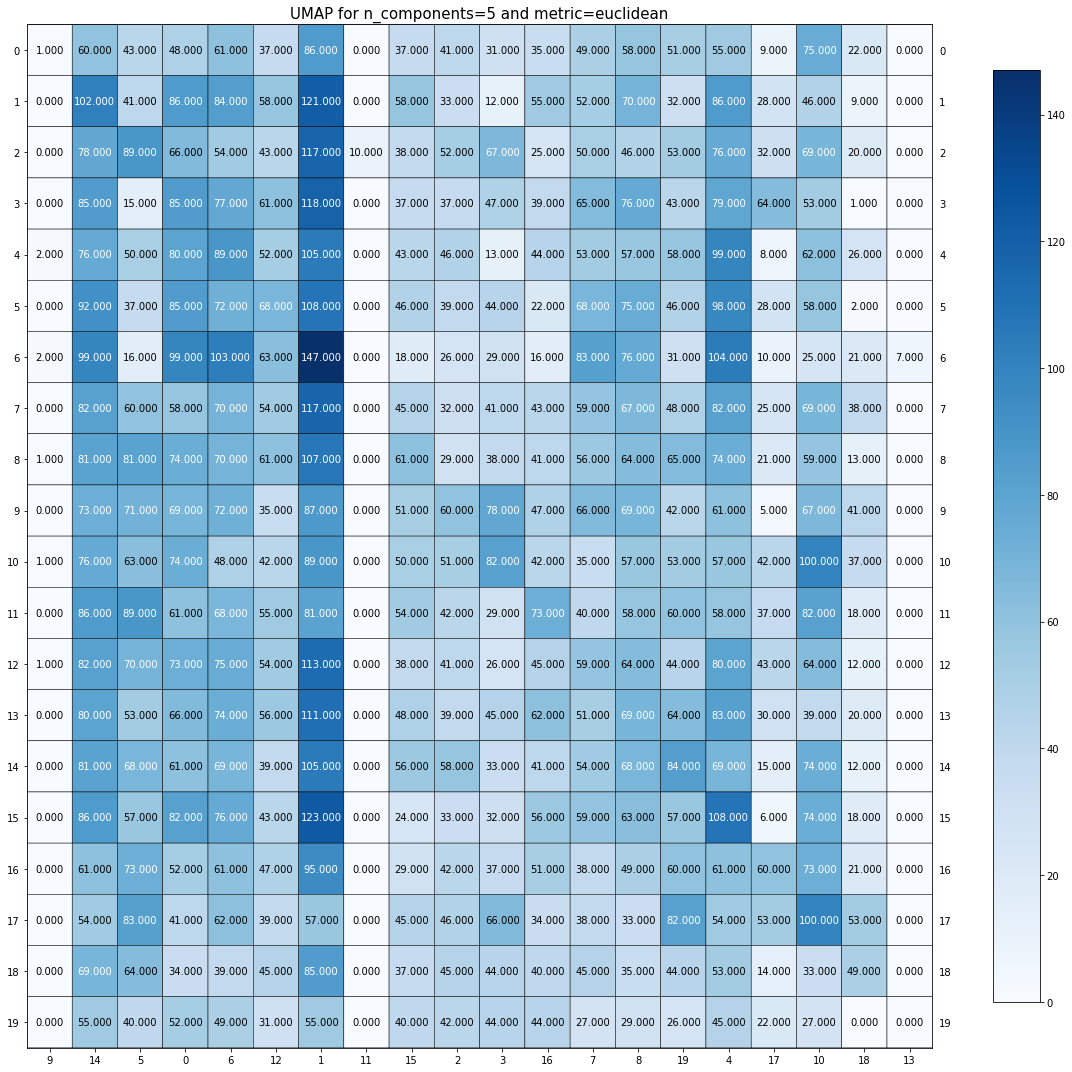

Homogeneity Score: 0.014609091532287627
Completeness: 0.015697714607844103
V-measure: 0.015133851352950665
Adjusted RI 0.002854246075200825
Adjusted MI 0.01186019186673016


In [32]:
umap_metrics(n_components=5, metric="euclidean", title="UMAP for n_components=5 and metric=euclidean")

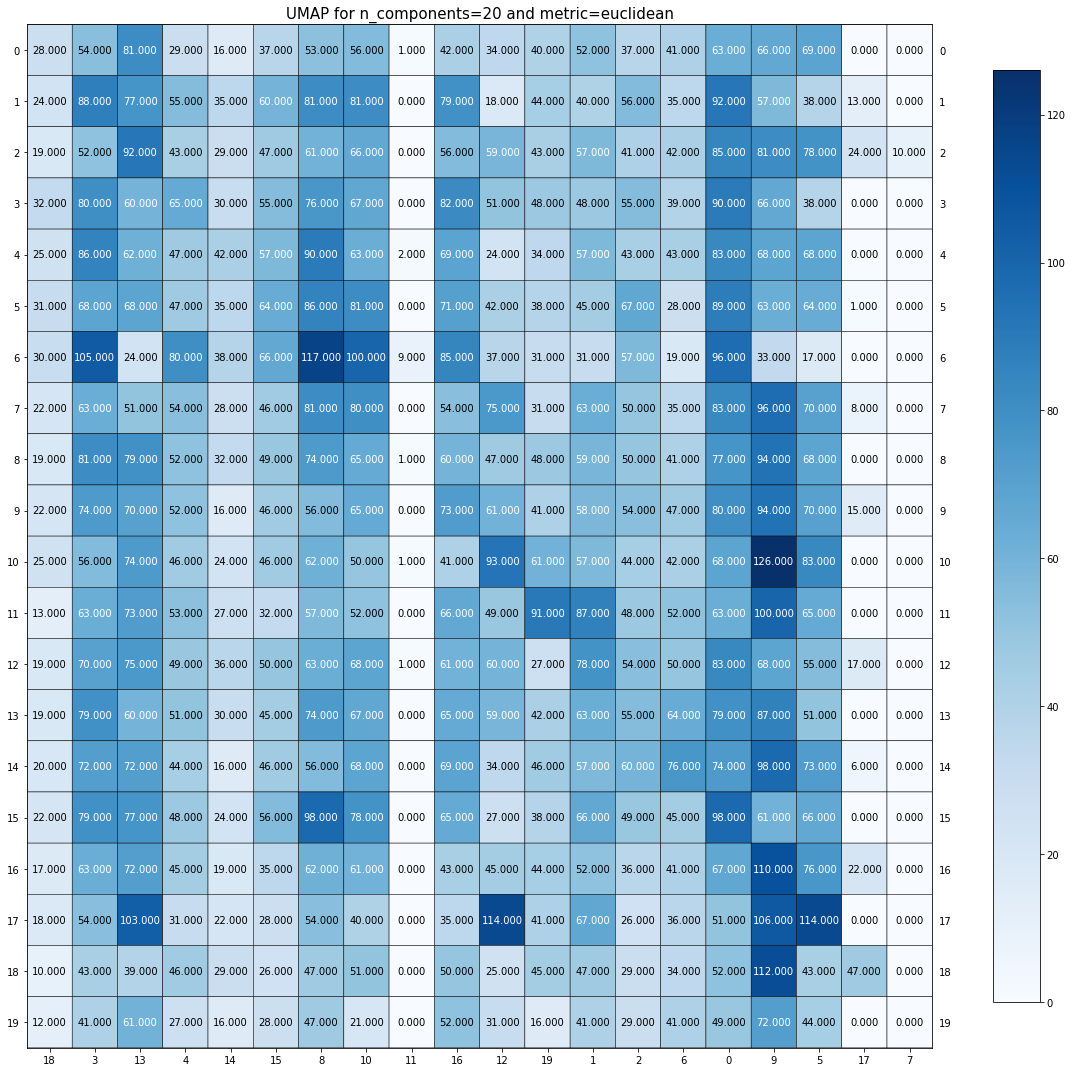

Homogeneity Score: 0.01438639461350556
Completeness: 0.015263170449296865
V-measure: 0.0148118188359035
Adjusted RI 0.002852245486350937
Adjusted MI 0.011509960261788143


In [33]:
umap_metrics(n_components=20, metric="euclidean", title="UMAP for n_components=20 and metric=euclidean")

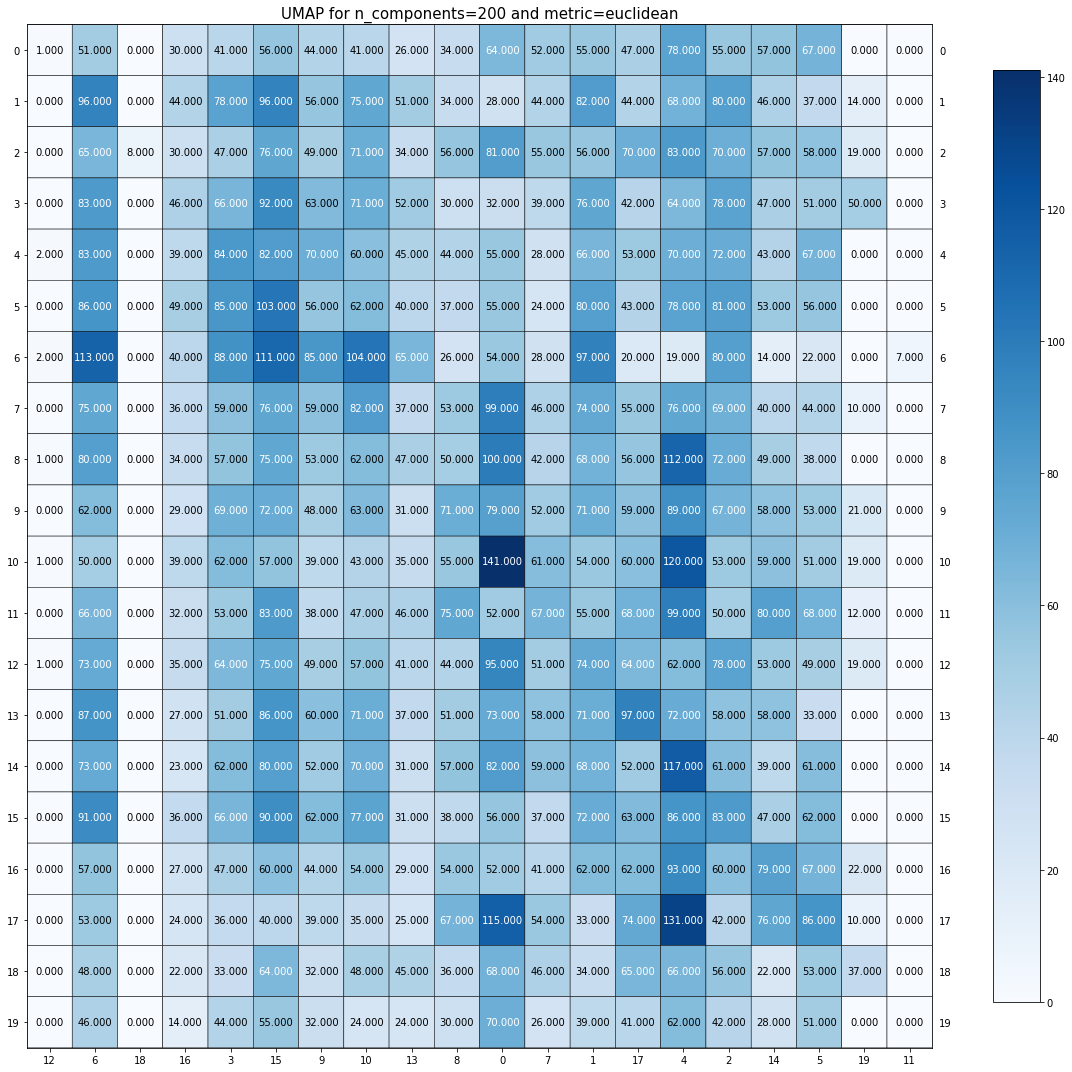

Homogeneity Score: 0.014994957245383243
Completeness: 0.016096460137258108
V-measure: 0.015526196737171455
Adjusted RI 0.0032262725677203517
Adjusted MI 0.0122662482636985


In [34]:
umap_metrics(n_components=200, metric="euclidean", title="UMAP for n_components=200 and metric=euclidean")

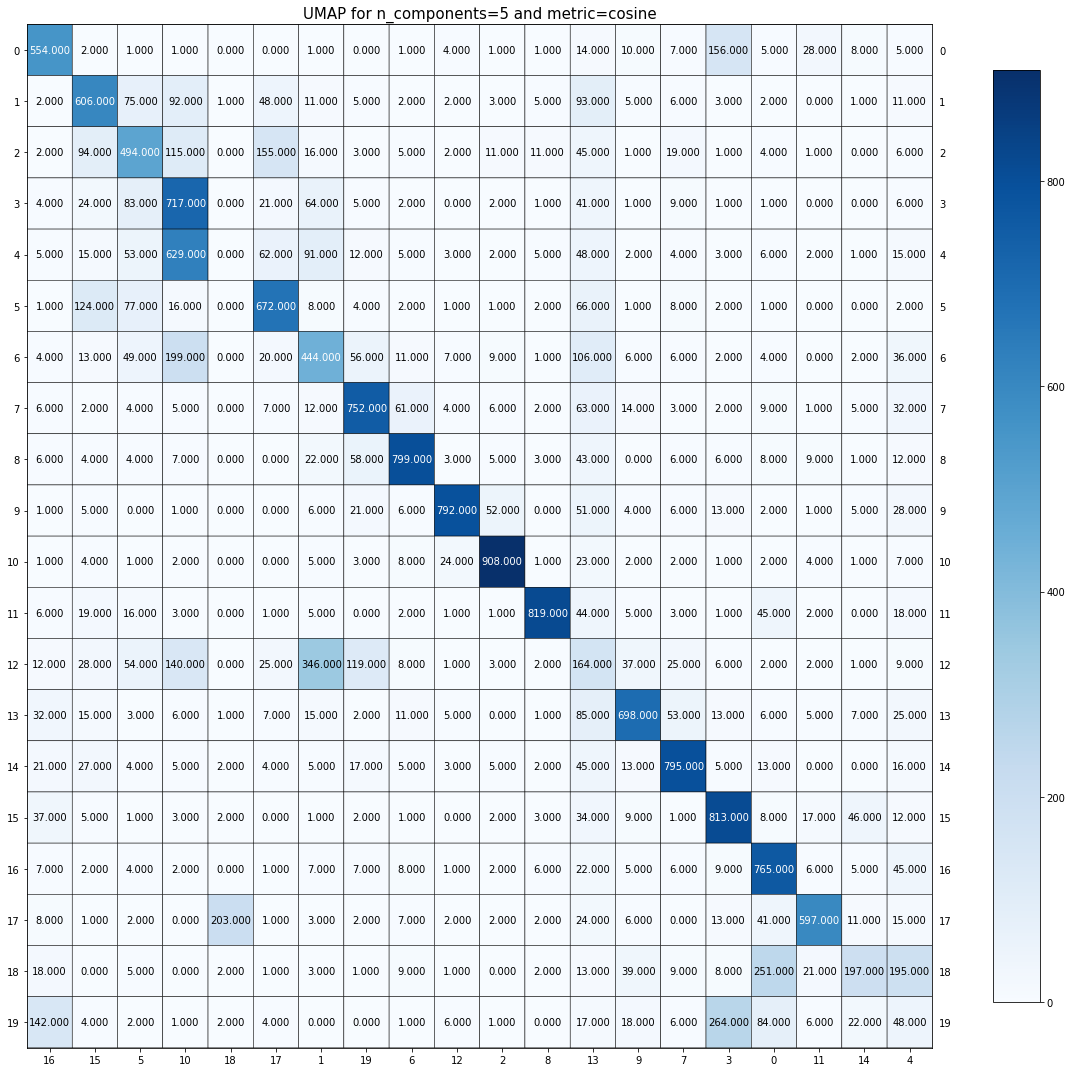

Homogeneity Score: 0.573063131404273
Completeness: 0.5864964429530796
V-measure: 0.5797019757996157
Adjusted RI 0.45613022764649963
Adjusted MI 0.5783286210097325


In [35]:
umap_metrics(n_components=5, metric="cosine", title="UMAP for n_components=5 and metric=cosine")

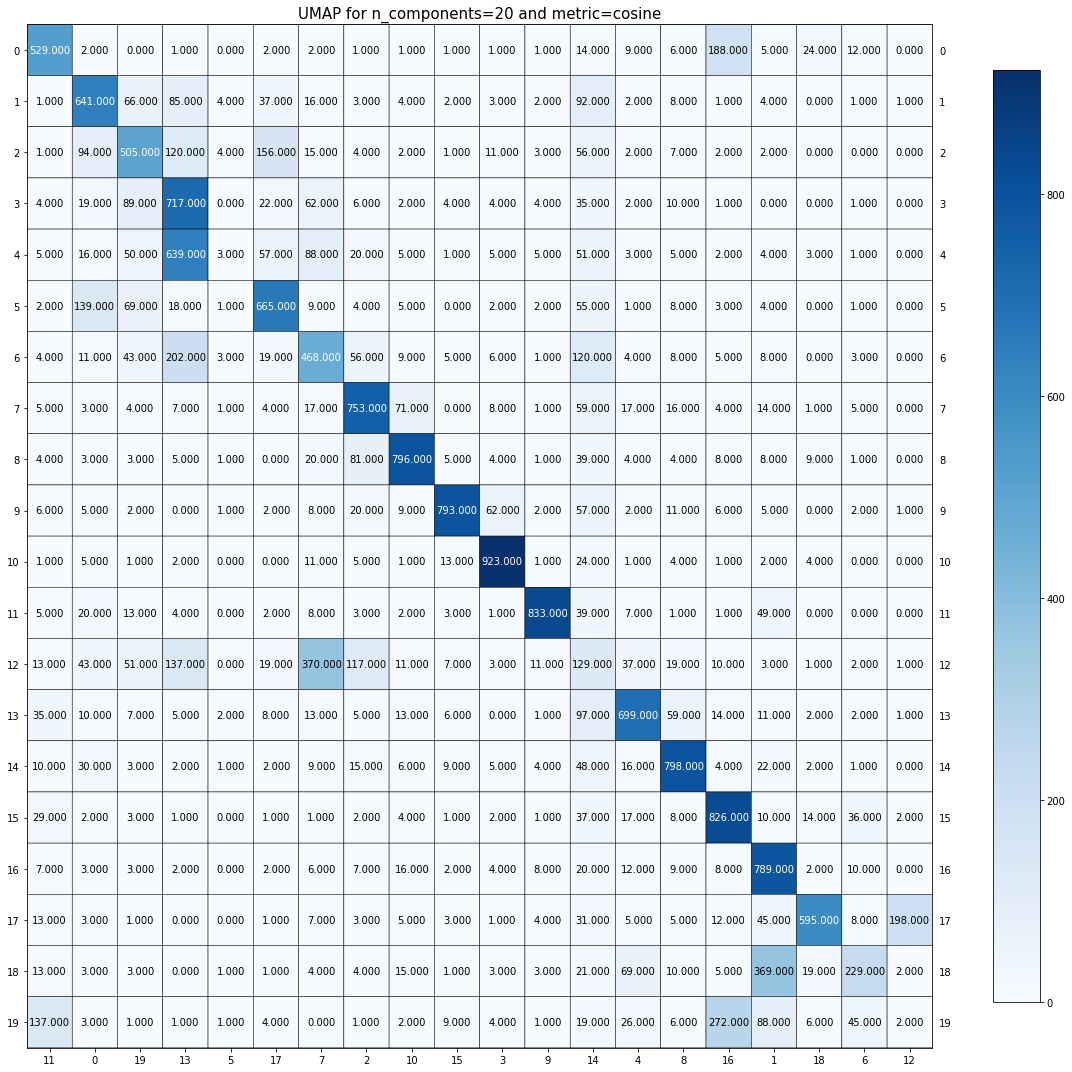

Homogeneity Score: 0.5722950878574007
Completeness: 0.5944802999251327
V-measure: 0.5831767777030937
Adjusted RI 0.4567080871600432
Adjusted MI 0.5817930960251217


In [36]:
umap_metrics(n_components=20, metric="cosine", title="UMAP for n_components=20 and metric=cosine")

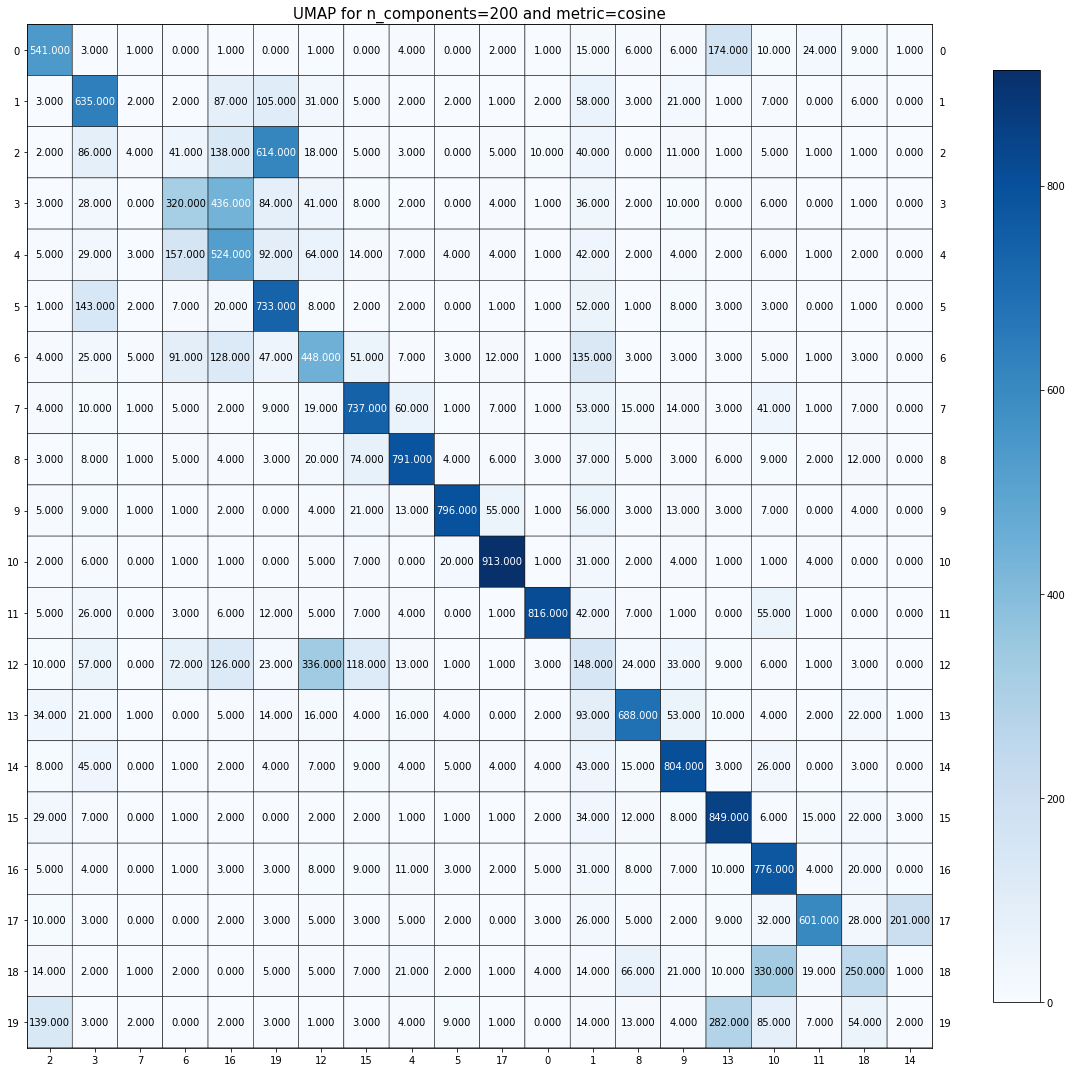

Homogeneity Score: 0.564586981277977
Completeness: 0.5858709972477733
V-measure: 0.5750321070888809
Adjusted RI 0.44453666969983924
Adjusted MI 0.573622118041904


In [37]:
umap_metrics(n_components=200, metric="cosine", title="UMAP for n_components=200 and metric=cosine")

### QUESTION 12: Analyze the contingency matrices. Which setting works best and why? What about for each metric choice?

The UMAP setting with **n_components = 200 and metric = cosine** works best in terms of the contingency matrix as well as the 5 evaluation measures compared to the rest of the combinations. This is because setting a higher number of components allows UMAP to better capture complex patterns within the data leading to better clustering. The Cosine similarity metric is better in comparison to Euclidean distance as it is ideal for high-dimensional/ sparse data where curse of dimensionality can affect the results. Euclidean is better equipped for data that exhibit linear relationships. 

In [38]:
for i in range(0,6):
  print(eval_scores['n_components'][i])
  print(eval_scores['metric'][i])
  print(eval_scores['h_score'][i])
  print(eval_scores['c_score'][i])
  print(eval_scores['v_score'][i])
  print(eval_scores['adj_rand'][i])
  print(eval_scores['adj_mutual_info'][i])

5
euclidean
0.014609091532287627
0.015697714607844103
0.015133851352950665
0.002854246075200825
0.01186019186673016
20
euclidean
0.01438639461350556
0.015263170449296865
0.0148118188359035
0.002852245486350937
0.011509960261788143
200
euclidean
0.014994957245383243
0.016096460137258108
0.015526196737171455
0.0032262725677203517
0.0122662482636985
5
cosine
0.573063131404273
0.5864964429530796
0.5797019757996157
0.45613022764649963
0.5783286210097325
20
cosine
0.5722950878574007
0.5944802999251327
0.5831767777030937
0.4567080871600432
0.5817930960251217
200
cosine
0.564586981277977
0.5858709972477733
0.5750321070888809
0.44453666969983924
0.573622118041904


### QUESTION 13: So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.

On comparing the 5 evaluation metrics for K-means clustering the UMAP reduced data with the setting n_components = 200 and metric = cosine gave the best results for K-means clustering among the 4 different representation learning techniques. 

### QUESTION 14: Use UMAP to reduce the dimensionality properly, and perform Agglomerative clustering with n_clusters=20 . Compare the performance of “ward” and “single” linkage criteria. Report the five clustering evaluation metrics for each case.

The Agglomerative performance of ward linkage was better than single linkage criteria on comparing the 5 clustering evaluation metrics. 

In [39]:
# Dimensionality Reduction using UMAP 
reducer20 = umap.UMAP(n_components=200, metric="cosine")
embedding20 = reducer20.fit_transform(X_train_tfidf20)

# Ground truth labels
ground_truth20 = newsgroups_data20.target

###  Agglomerative Clustering (Ward)

In [40]:
# Agglomerative Clustering for ward algorithm 

ward = AgglomerativeClustering(n_clusters = 20, affinity ="euclidean", linkage="ward")
ward.fit(embedding20)
ward_labels = ward.labels_ 

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [41]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, ward_labels)
c_score = completeness_score(ground_truth20,ward_labels) 
v_score = v_measure_score(ground_truth20,ward_labels)
adj_rand = adjusted_rand_score(ground_truth20, ward_labels)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, ward_labels)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.5657747385780165
Completeness: 0.5875369073722306
V-measure: 0.5764505046674958
Adjusted RI 0.43768097994417804
Adjusted MI 0.5750449287480054


###  Agglomerative Clustering (Single Linkage Criteria)

In [42]:
# Agglomerative Clustering for (Single Linkage Criteria) 

single = AgglomerativeClustering(n_clusters = 20, affinity ="euclidean", linkage="single")
single.fit(embedding20)
single_labels = single.labels_ 

/Users/vaniagrawal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [43]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, single_labels)
c_score = completeness_score(ground_truth20,single_labels) 
v_score = v_measure_score(ground_truth20,single_labels)
adj_rand = adjusted_rand_score(ground_truth20, single_labels)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, single_labels)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.01695239351921457
Completeness: 0.36823784187459485
V-measure: 0.03241262228645149
Adjusted RI 0.00046796298443246403
Adjusted MI 0.02770166493579416


## Question 15: 

### 15.1 Apply HDBSCAN on UMAP-transformed 20-category data. Use min_cluster_size=100.

In [44]:
# Dimensionality Reduction using UMAP 
reducer20 = umap.UMAP(n_components=200, metric="cosine")
embedding20 = reducer20.fit_transform(X_train_tfidf20)

# Ground truth labels
ground_truth20 = newsgroups_data20.target

# HDBSCAN model
min_cluster_size = 100
hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size)
hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

In [45]:
# 5 clustering Evaluation Metrics
h_score = homogeneity_score(ground_truth20, hdbscan_cluster)
c_score = completeness_score(ground_truth20,hdbscan_cluster) 
v_score = v_measure_score(ground_truth20,hdbscan_cluster)
adj_rand = adjusted_rand_score(ground_truth20, hdbscan_cluster)
adj_mutual_info = adjusted_mutual_info_score(ground_truth20, hdbscan_cluster)

# Prints 5 clustering Evaluation Metrics 
print("Homogeneity Score:", h_score)
print("Completeness:", c_score)
print("V-measure:", v_score)
print("Adjusted RI", adj_rand)
print("Adjusted MI", adj_mutual_info)

Homogeneity Score: 0.4190806671652832
Completeness: 0.6166314252622905
V-measure: 0.49901572258039667
Adjusted RI 0.20196227347874798
Adjusted MI 0.4977949782155543


### 15.2 Vary the min cluster size among 20, 100, 200 and report your findings in terms of the five clustering evaluation metrics - you will plot the best contingency matrix in the next question. Feel free to try modifying other parameters in HDBSCAN to get better performance.

In [46]:
min_cluster_sizes = [20, 100, 200]

for cluster_size in min_cluster_sizes:
    # Dimensionality Reduction using UMAP 
    reducer20 = umap.UMAP(n_components=200, metric="cosine")
    embedding20 = reducer20.fit_transform(X_train_tfidf20)

    # Ground truth labels
    ground_truth20 = newsgroups_data20.target

    # HDBSCAN model
    hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = cluster_size)
    hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

    # 5 clustering Evaluation Metrics
    h_score = homogeneity_score(ground_truth20, hdbscan_cluster)
    c_score = completeness_score(ground_truth20,hdbscan_cluster) 
    v_score = v_measure_score(ground_truth20,hdbscan_cluster)
    adj_rand = adjusted_rand_score(ground_truth20, hdbscan_cluster)
    adj_mutual_info = adjusted_mutual_info_score(ground_truth20, hdbscan_cluster)

    # Prints 5 clustering Evaluation Metrics for each min_cluster_size
    print("-"*20 + f" HDBSCAN clustering with min_cluster_size={cluster_size} " + "-"*20)
    print("Homogeneity Score:", h_score)
    print("Completeness:", c_score)
    print("V-measure:", v_score)
    print("Adjusted RI", adj_rand)
    print("Adjusted MI", adj_mutual_info)

-------------------- HDBSCAN clustering with min_cluster_size=20 --------------------
Homogeneity Score: 0.4162914667318007
Completeness: 0.43305407272219654
V-measure: 0.4245073570966044
Adjusted RI 0.06390645681972563
Adjusted MI 0.41092792978375625
-------------------- HDBSCAN clustering with min_cluster_size=100 --------------------
Homogeneity Score: 0.42267329012263655
Completeness: 0.6179261319474856
V-measure: 0.5019815804306648
Adjusted RI 0.22145540038735279
Adjusted MI 0.5009773908638369
-------------------- HDBSCAN clustering with min_cluster_size=200 --------------------
Homogeneity Score: 0.4110517095808222
Completeness: 0.6042128469358168
V-measure: 0.4892571538905934
Adjusted RI 0.20558464620370817
Adjusted MI 0.48822498303646295


## Question 16

### 16.1 Plot the contingency matrix for the best clustering model from Question 15.

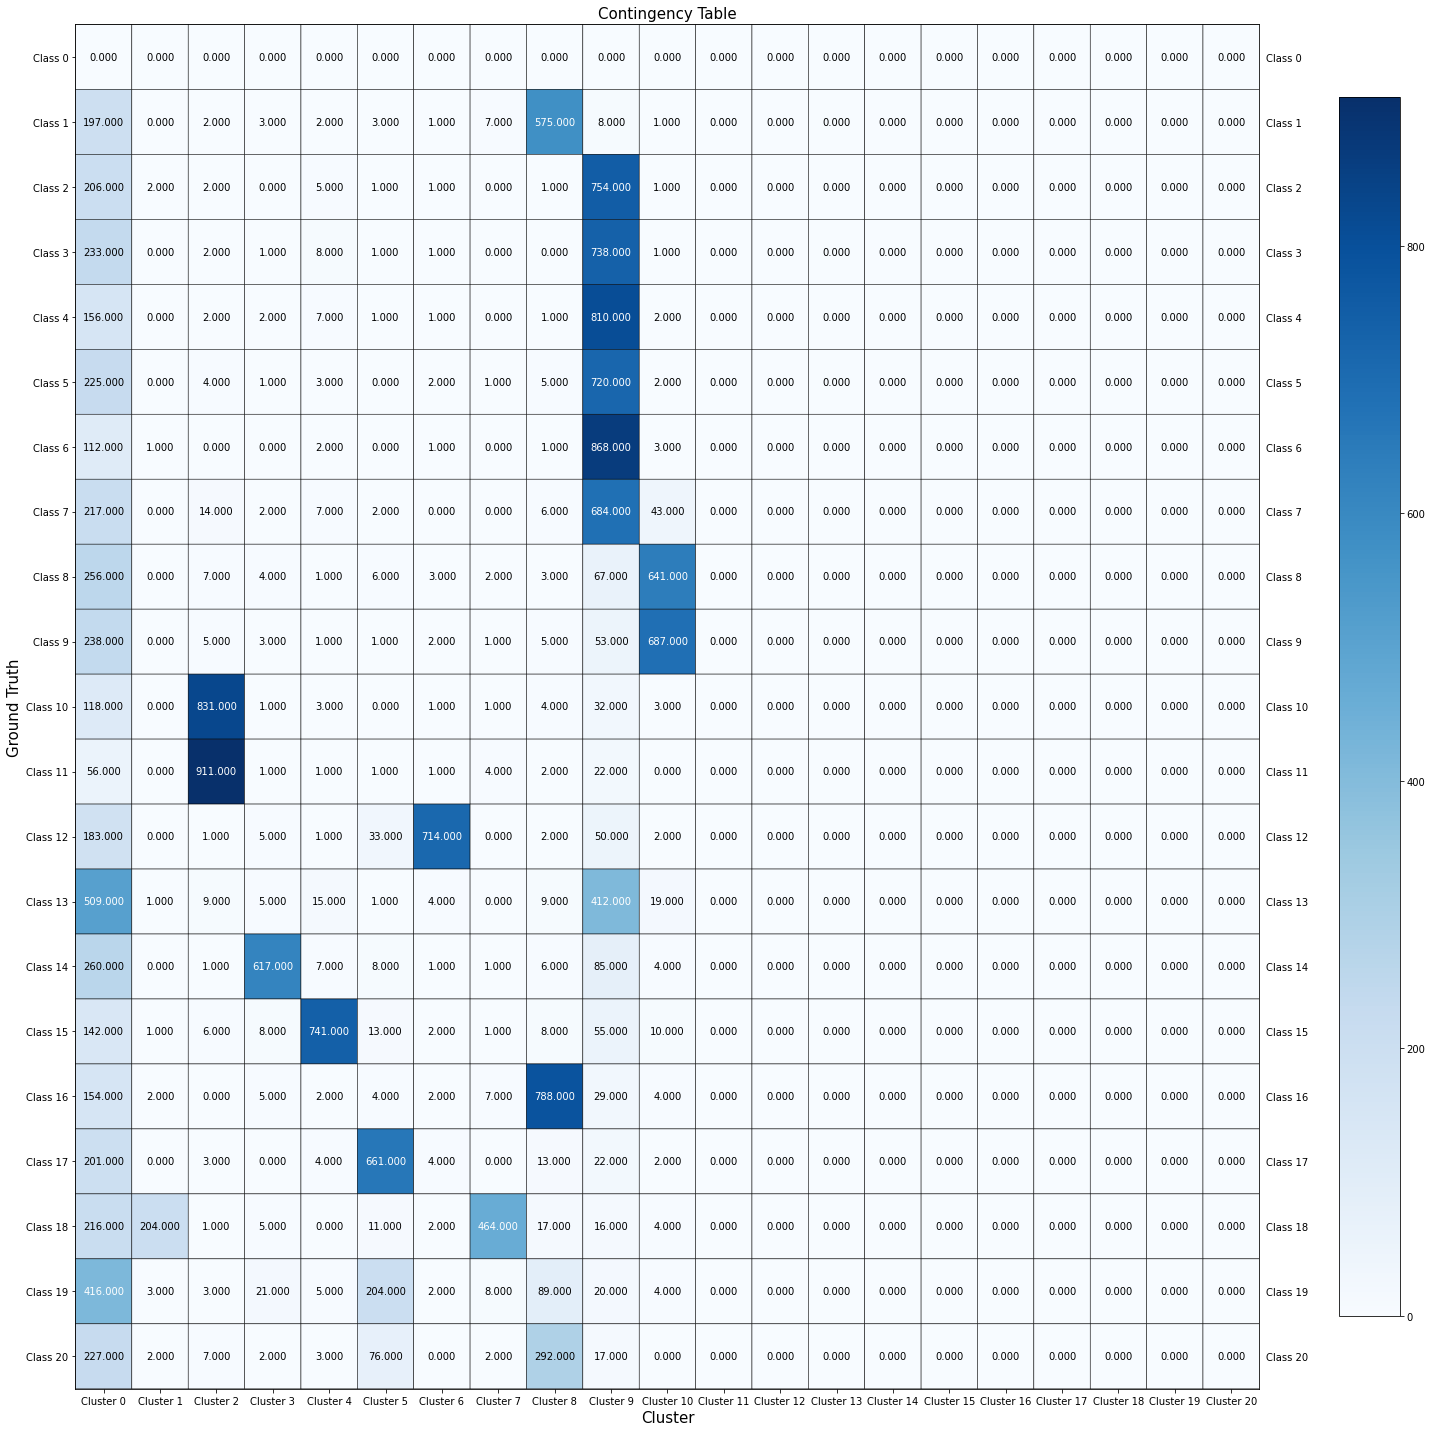

In [48]:
# Ground truth labels
ground_truth20 = newsgroups_data20.target

# Best HDBSCAN model
best_min_cluster_size = 100
best_hdbscan_mod = hdbscan.HDBSCAN(min_cluster_size = best_min_cluster_size)
best_hdbscan_cluster = hdbscan_mod.fit_predict(embedding20)

mat_hdbscan20 = confusion_matrix(ground_truth20, best_hdbscan_cluster)

# Visualizing the matrix using plotmat.py
xlabels = [f'Cluster {i}'.format(i) for i in range(0,21)]
ylabels = [f'Class {i}'.format(i) for i in range(0,21)]
plotmat.plot_mat(mat_hdbscan20, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(20,20), title="Contingency Table")

### 16.2 How many clusters are given by the model? What does “-1” mean for the clustering labels? Interpret the contingency matrix considering the answer to these questions.

# Part 2 - Deep Learning and Clustering of Image Data

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


c:\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Initializing Dataset

In [3]:
filename = './flowers_features_and_labels.npz'

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Feature Extraction 
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Initializes the VGG Model 
        vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

        # Extract VGG-16 Feature Layers
        self.features = list(vgg.features)
        self.features = nn.Sequential(*self.features)
        # Extract VGG-16 Average Pooling Layer
        self.pooling = vgg.avgpool
        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        # Extract the first part of fully-connected layer from VGG16
        self.fc = vgg.classifier[0]

    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out) 
        return out 


if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    # Initialize the model
    # assert torch.cuda.is_available()
    # feature_extractor = FeatureExtractor().cuda().eval()
    feature_extractor = FeatureExtractor().to(device).eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            x = x.to(device)
            f_all = np.vstack([f_all, feature_extractor(x).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [4]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


PCA

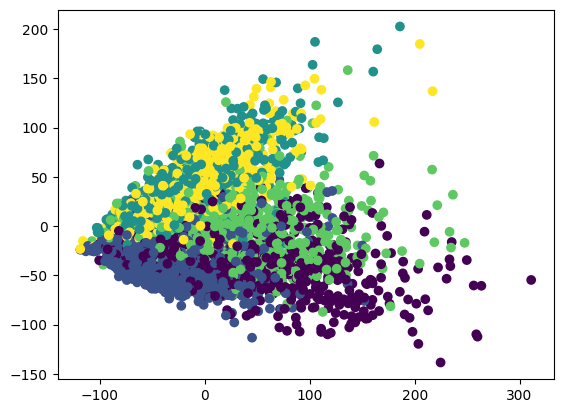

In [4]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

MLP Classifier

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        # self.cuda()
        self.to(device)
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        # X = torch.tensor(X, dtype=torch.float32, device='cuda')
        # y = torch.tensor(y, dtype=torch.int64, device='cuda')
        X = torch.tensor(X, dtype=torch.float32, device=device)
        y = torch.tensor(y, dtype=torch.int64, device=device)
    
        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                optimizer.zero_grad()
                outputs = self.model(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
        y_test = torch.tensor(y_test, dtype=torch.int64, device=device)

        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            outputs = self.model(X_test)
            _, predicted = torch.max(outputs, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

        accuracy = correct / total
        print('Accuracy on test set: {:.2%}'.format(accuracy))

        return accuracy

Autoencoder

In [31]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        # self.cuda()
        self.to(device)
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                # X_ = X_.cuda()
                X_ = X_.to(device)
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [13:45<00:00, 13.84s/it]


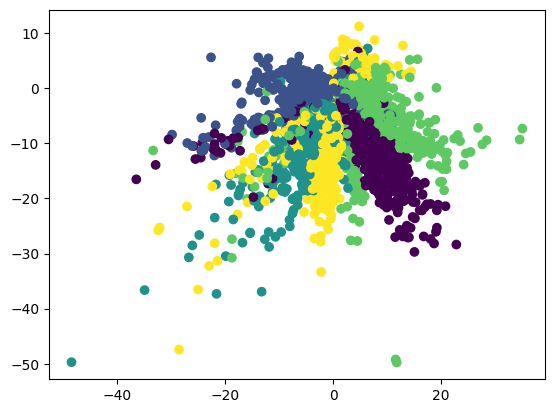

In [8]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

## Question 19

### 19.1 In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

Having discriminative power means that a model or a set of features are able to effectively distinguish between different classes/categories of a dataset. With regard to the pretrained VGG network, the already learned features carry relevant information that can distinguish patterns within the data. Because it has extracted features, these learned representations can exhibit descriminative power because the earlier layers capture general patterns. Even if the final layer can be more specific to the original dataset's features/classes, the earlier layers are more generic. Those earlier layers can be used as an input to a new classifier to leverage that discriminative power that was learned in the pretraining of the VGG network. 

Note: the original is huge and generic. VGG uses CNN and users hierarchical, lower layers captures edges and textures while the higher levels capture semantic features. These are all applicable across datasets so it generalizes well. 

## Question 20

### In a brief paragraph explain how the helper code base is performing feature extraction.

First, the data checks for the 'flowers_features_and_labels.npz' file. If it exists, it loads the precomputed features ('f_all') and labels ('y_all'). If it does not exist, it downloads the dataset from the TensorFlow website. Second, the Feature Extractor class is instantiated. It initializes the VGG model and extracts the feature extraction layers. It also includes the average pooling layer and then flattens the image into a one-dimensional vector as well as the first part of the fully-connected layer. Third, the ImageFolder loads the Flowers dataset applying different transformation such as Resize, CenterCrop, ToTensor, and Normalize. Forth, the DataLoad is instantiated to create batches of the dataset. Lastly, for each batch of images, the features and labels are extracted and stored in the device. After processing through all the batches, the extracted features and labels are saved as a compressed NumPy file. 

## Question 21

### How many pixels are there in the original images? 

In [9]:
import os
from PIL import Image

# Directory path containing the dataset
dataset_directory = './flower_photos'

# Create a list to store pixel counts
pixel_counts = []
min_pixel_count = float('inf')
max_pixel_count = 0

# Iterate through all files in the dataset directory
for root, dirs, files in os.walk(dataset_directory):
    for file in files:
        # Construct the full path to the image
        image_path = os.path.join(root, file)

        # Check if the file is an image (skip non-image files)
        if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            continue

        try:
            # Open the image and get its size
            with Image.open(image_path) as img:
                image_size = img.size
                # Calculate pixel count
                pixel_count = image_size[0] * image_size[1]
                pixel_counts.append((file, pixel_count))
                # Update minimum and maximum pixel count values
                min_pixel_count = min(min_pixel_count, pixel_count)
                max_pixel_count = max(max_pixel_count, pixel_count)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Print the table header
print(f"{'Image Filename':<40}{'Pixel Count':<15}")

# Print the pixel counts in a table
for filename, count in pixel_counts:
    print(f"{filename:<40}{count:<15}")


Image Filename                          Pixel Count    
100080576_f52e8ee070_n.jpg              84160          
10140303196_b88d3d6cec.jpg              156500         
10172379554_b296050f82_n.jpg            68800          
10172567486_2748826a8b.jpg              166500         
10172636503_21bededa75_n.jpg            80000          
102841525_bd6628ae3c.jpg                200000         
1031799732_e7f4008c03.jpg               187500         
10391248763_1d16681106_n.jpg            71680          
10437754174_22ec990b77_m.jpg            41040          
10437770546_8bb6f7bdd3_m.jpg            57600          
10437929963_bc13eebe0c.jpg              160000         
10466290366_cc72e33532.jpg              166500         
10466558316_a7198b87e2.jpg              166500         
10555749515_13a12a026e.jpg              165500         
10555815624_dc211569b0.jpg              160000         
10555826524_423eb8bf71_n.jpg            70080          
10559679065_50d2b16f6d.jpg              140500  

In [10]:
print(f"Minimum Pixel Count: {min_pixel_count}")
print(f"Maximum Pixel Count: {max_pixel_count}")

Minimum Pixel Count: 34320
Maximum Pixel Count: 221000


The pixel count varied from 34320 to 221000 pixels in the original images. In the resized images, the dimensions are 224x224 which is 50176 pixels. 

### How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?

In [19]:
feature_extractor = FeatureExtractor().to(device).eval()

dummy_dataset = datasets.ImageFolder(root='./flower_photos',
                                transform=transforms.Compose([transforms.Resize(224),
                                                                transforms.CenterCrop(224),
                                                                transforms.ToTensor(),
                                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
dummy_dataloader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)
dimension_of_feature_vectors = []
for x, _ in tqdm(dummy_dataloader):
    with torch.no_grad():
        x = x.to(device)
        feature_vectors = feature_extractor(x)
        for feature_vector in feature_vectors:
            dimension_of_feature_vector = feature_vector.size(0)
            dimension_of_feature_vectors.append(dimension_of_feature_vector)
        break

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/58 [00:00<?, ?it/s]

In [20]:
dimension_str = ', '.join(map(str, np.unique(dimension_of_feature_vectors)))
print("Dimension of the feature vector: " + dimension_str)

Dimension of the feature vector: 4096


In [ ]:
print("Dimension of the feature vector: " + f_all.shape[1])

## Question 22

### Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)

In [21]:
dummy_dataloader = DataLoader(dummy_dataset, batch_size=1, shuffle=True)

# Extract features from a sample image
for x, _ in dummy_dataloader:
    with torch.no_grad():
        x = x.to(device)
        feature_vector = feature_extractor(x)
        
        # Convert the PyTorch tensor to a NumPy array
        feature_vector_np = feature_vector.cpu().numpy()

        # Sparsity ratio
        sparsity_ratio = 1.0 - np.count_nonzero(feature_vector_np) / feature_vector_np.size
        print(f"Sparsity Ratio of the feature vector: {sparsity_ratio:.4f}")

        # Print the entire feature vector for reference
        # print("Feature Vector:")
        # print(feature_vector_np)
        break  # Break after processing the first batch for illustration

Sparsity Ratio of the feature vector: 0.0000


In [ ]:
# count the size of f_all and count the number of nonzero/size 

Sparsity is low and that means the extracted features are dense. In TF-IDF has a lot of zero values which is why we do dimensionality reduction for TF-IDF

***incomplete***

## Question 23

### In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.

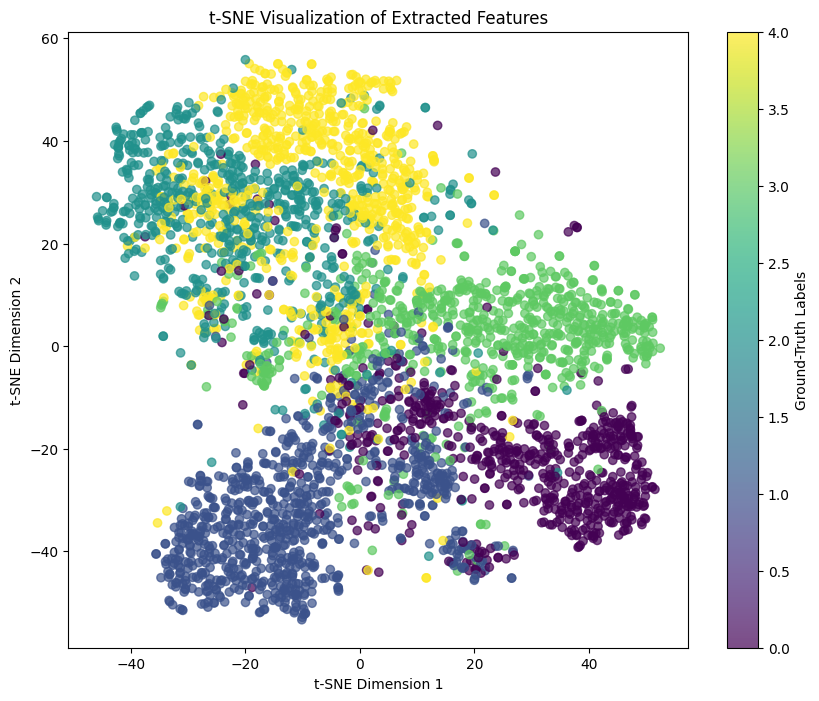

In [22]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
mapped_features = tsne.fit_transform(f_all)

# Plot the mapped feature vectors with color-coded ground-truth labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mapped_features[:, 0], mapped_features[:, 1], c=y_all, cmap='viridis', alpha=0.7)

# Add colorbar for reference
cbar = plt.colorbar(scatter)
cbar.set_label('Ground-Truth Labels')

plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In this graph, you can see that there are visible clusters. Higher Ground-Truth labels were along the higher Dimension 2 while the lower Ground-Truth labels were towards the negatives. For instance, Ground Truth value of aprpoximately 1 (Blue) were in Quadrant III where the Dimension 1 and Dimension 2 were negative. Ground Truth value of 0 (Purple) are in Quadrant IV where it has a positive Dimension 1 but negative Dimension 2. Label value of 3 (light green) are at positive Dimension 1 but Dimension 2 at 0. Label value of 4 and 2 are both in the negative Dimension 1 and positive Dimension 2. 

## Question 24

### Report the best result (in terms of rand score) within the table below. For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

In [33]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from umap import UMAP
import hdbscan
from sklearn.preprocessing import StandardScaler

MIN_CLUSTER_SIZE = 5
MIN_SAMPLES = 1
filename = './flowers_features_and_labels.npz'
file = np.load(filename)
f_all, y_all = file['f_all'], file['y_all']

# Helper function for clustering evaluation
def evaluate_clustering(true_labels, predicted_labels):
    rand_score = adjusted_rand_score(true_labels, predicted_labels)
    return rand_score

# Dimensionality Reduction Techniques
dimensionality_reduction_methods = [
    ('None', None),  # No dimensionality reduction
    ('SVD', TruncatedSVD(n_components=50)),
    ('UMAP', UMAP(n_components=50)),
    ('Autoencoder', Autoencoder(n_components=50))  # Assuming Autoencoder is already defined
]

# Clustering Algorithms
clustering_algorithms = [
    ('K-Means', KMeans(n_clusters=5)),
    ('Agglomerative', AgglomerativeClustering(n_clusters=5)),
    ('HDBSCAN', hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES))  # You need to define MIN_CLUSTER_SIZE and MIN_SAMPLES
]

# Perform Clustering and Evaluate
results = []

for reduction_name, reduction_method in dimensionality_reduction_methods:
    if reduction_method is not None:
        X_reduced = reduction_method.fit_transform(f_all)
    else:
        X_reduced = f_all

    for clustering_name, clustering_algorithm in clustering_algorithms:
        if clustering_name == 'HDBSCAN':
            # HDBSCAN needs to be fitted on the reduced data
            clusterer = clustering_algorithm.fit(X_reduced)
            predicted_labels = clusterer.labels_
        else:
            # Other clustering algorithms are fitted on the original data
            clusterer = clustering_algorithm.fit(f_all)
            predicted_labels = clusterer.labels_

        rand_score = evaluate_clustering(y_all, predicted_labels)
        results.append((reduction_name, clustering_name, rand_score))

# Find the best result based on Rand score
best_result = max(results, key=lambda x: x[2])

# Print the results
print("Best Result (in terms of Rand score):")
print("Dimensionality Reduction: ", best_result[0])
print("Clustering Algorithm: ", best_result[1])
print("Rand Score: ", best_result[2])


100%|██████████| 100/100 [25:32<00:00, 23.86s/it]


Best Result (in terms of Rand score):
Dimensionality Reduction:  Autoencoder
Clustering Algorithm:  K-Means
Rand Score:  0.2313531846272586


## Question 25

### Report the test accuracy of the MLP classifier on the original VGG features. 

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

filename = './flowers_features_and_labels.npz'
file = np.load(filename)
f_all, y_all = file['f_all'], file['y_all']

# Define MLP model and optimizer
num_features = f_all.shape[1] 
num_labels = len(np.unique(y_all))
mlp_model = MLP(num_features=num_features)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

# Train the MLP on original VGG features
mlp_model.train(X_train, Y_train)

# Evaluate on the test set
mlp_model.eval(X_test, Y_test)

100%|██████████| 100/100 [03:44<00:00,  2.56s/it]


Accuracy on test set: 91.01%


0.9100817438692098

### Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). 

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

filename = './flowers_features_and_labels.npz'
file = np.load(filename)
f_all, y_all = file['f_all'], file['y_all']

num_features = f_all.shape[1]  
num_labels = len(np.unique(y_all))
num_components = 50

# Dimensionality Reduction
autoencoder = Autoencoder(n_components=num_components)
f_all_autoencoder = autoencoder.fit_transform(f_all)
num_features = f_all_autoencoder.shape[1] 

# Define MLP model and optimizer
mlp_model = MLP(num_features=num_features)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(f_all_autoencoder, y_all, test_size=0.2, random_state=42)

# Train the MLP on original VGG features
mlp_model.train(X_train, Y_train)

# Evaluate on the test set
mlp_model.eval(X_test, Y_test)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:03<00:00,  1.43it/s]


Accuracy on test set: 88.01%


0.8801089918256131

### Does the performance of the model suffer with the reduced-dimension representations? 

The performance does suffer with the reduced dimension because it compressions the original features into a lower-dimensional space. It can simplify the model before it was reduced, but that can cause a loss of the complex patterns captured in the original pattern. 

### Is it significant? 

The difference in accuracy is not significant. Before dimensionality reduction, the accuracy was 91.01% while with the dimensionality reduction, the accuracy was 88.01%. This is somewhat significant because the difference is about 3%. 

### Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 24.

In [54]:
results = []
print("Result (in terms of Rand score)")
print("-------------------------------")

for clustering_name, clustering_algorithm in clustering_algorithms:
    if clustering_name == 'HDBSCAN':
        # HDBSCAN needs to be fitted on the reduced data
        clusterer = clustering_algorithm.fit(f_all_autoencoder)
        predicted_labels = clusterer.labels_
    else:
        # Other clustering algorithms are fitted on the original data
        clusterer = clustering_algorithm.fit(f_all)
        predicted_labels = clusterer.labels_

    rand_score = evaluate_clustering(y_all, predicted_labels)
    results.append((clustering_name, rand_score))

    print("Clustering Algorithm: ", clustering_name)
    print("Rand Score: ", rand_score)

Result (in terms of Rand score)
-------------------------------
Clustering Algorithm:  K-Means
Rand Score:  0.21629238487597463
Clustering Algorithm:  Agglomerative
Rand Score:  0.2972395054903007
Clustering Algorithm:  HDBSCAN
Rand Score:  0.019098408015701188


The classification does not make sense because the accuracy is high for the classification but the Rand Score is relatively low, especially for K-Means and Agglomerative. 

***not complete or probably correct***

# Part 3 - Clustering using both image and text

In [ ]:
!pip install datasets transformers numpy pandas Pillow matplotlib --user
!pip install torch tqdm scipy --user
!pip install git+https://github.com/openai/CLIP.git --user
!pip install plotly umap-learn --user

In [6]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
# import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [10]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    # image_embeddings = np.concatenate(image_embeddings, axis=0)
    # image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    if image_embeddings:  # Check if the list is not empty
        image_embeddings = np.concatenate(image_embeddings, axis=0)  # Concatenate embeddings
        image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    else:
        image_embeddings = np.empty((0, 512))  # Create an empty array if no embeddings are found

    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

## Question 26

Try to construct various text queries regarding types of Pokemon (such as ”type: Bug”, ”electric type Pokemon” or ”Pokemon with fire abilities”) to find the relevant images from the dataset. 

In [13]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from glob import glob
import torch
import clip
from scipy.special import softmax

# Load the Pokedex data
pokedex = construct_pokedex()

# Construct text queries for various types of Pokemon
queries = {
    "Bug": "type: Bug",
    "Fire": "type: Fire",
    "Grass": "type: Grass",
    "Dark": "type: Dark",
    "Dragon": "type: Dragon"
}

# Load CLIP model
model, preprocess, device = load_clip_model()

# Encode text queries
query_embeddings = clip_inference_text(model, preprocess, list(queries.values()), device)

# Encode image descriptions
image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"], device)


100%|██████████| 754/754 [36:08<00:00,  2.88s/it]


Once you have found the most suitable template for queries, please find the top five most relevant Pokemon for type Bug, Fire and Grass. For each of the constructed query, please plot the five most relevant Pokemon horizontally in one figure with following specifications:

1) the title of the figure should be the query you used;
2) the title of each Pokemon should be the name of the Pokemon and its first and second type.

Repeat this process for Pokemon of Dark and Dragon types. 

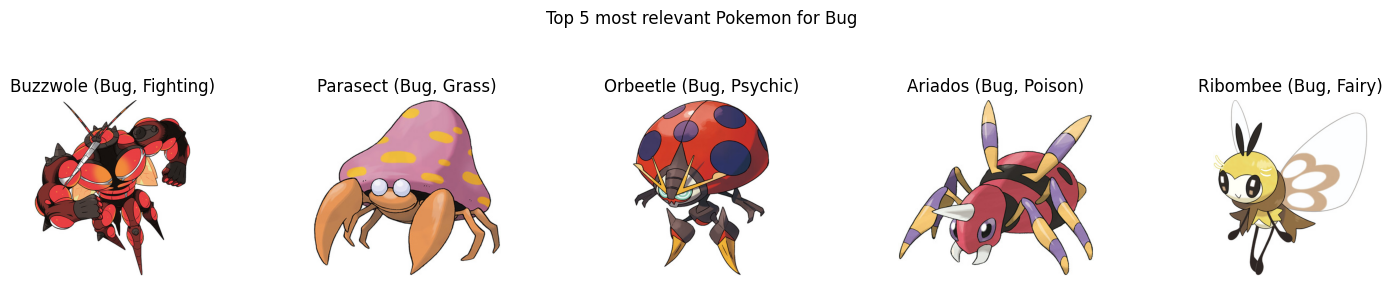

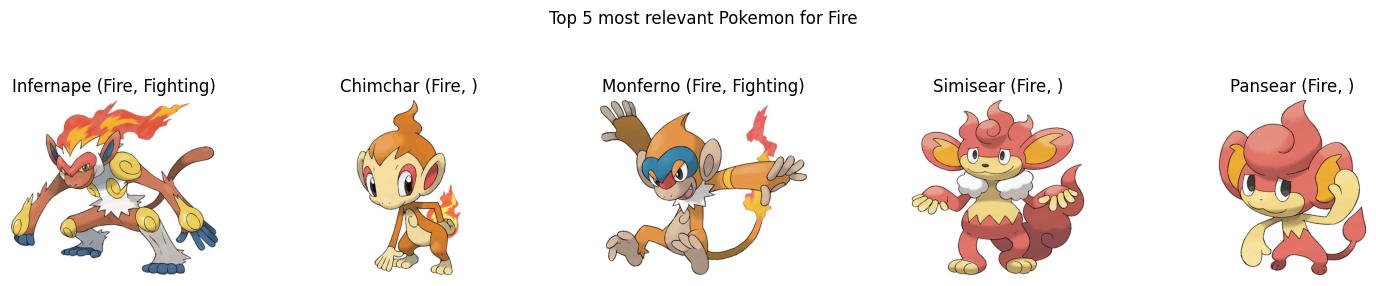

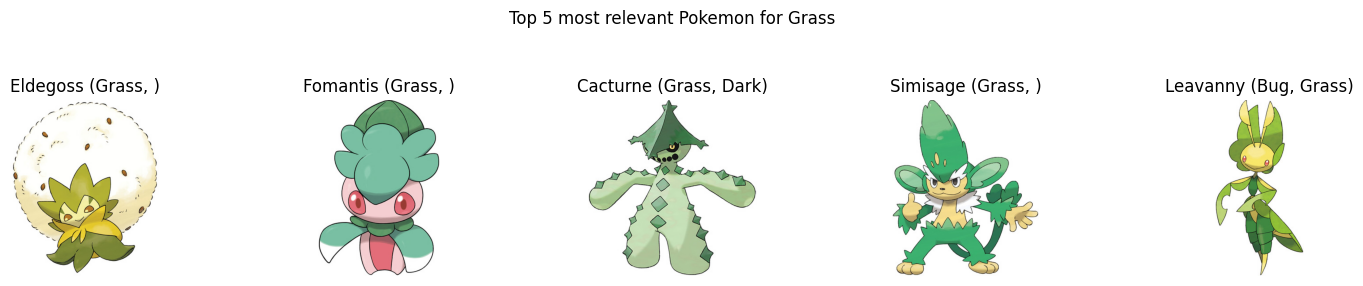

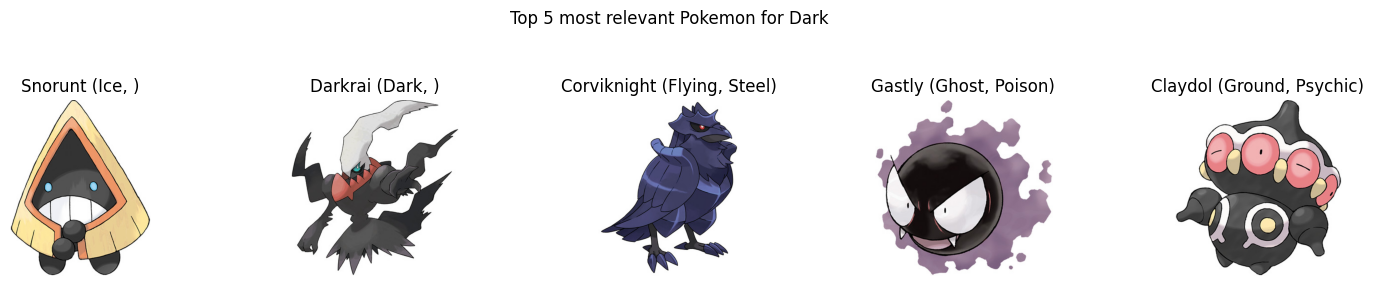

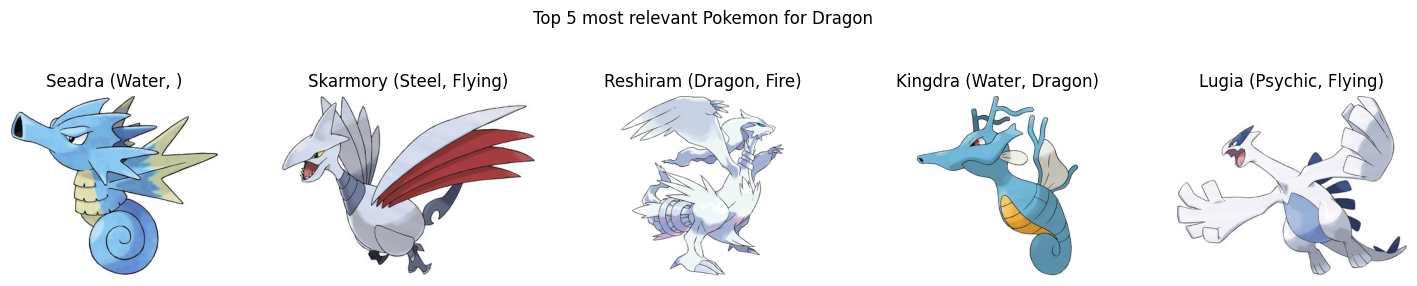

In [15]:
# Compute similarity between text queries and image descriptions
similarities = compute_similarity_text_to_image(image_embeddings, query_embeddings)

# Find the top five most relevant images for each type
top_k_indices = np.argsort(similarities, axis=0)[-5:][::-1]

# Plot the top five most relevant Pokemon horizontally for each type
import matplotlib.pyplot as plt

for type_name, indices in zip(queries.keys(), top_k_indices.T):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Top 5 most relevant Pokemon for {type_name}")
    for i, idx in enumerate(indices):
        pokemon_name = pokedex.iloc[idx]["Name"]
        pokemon_type1 = pokedex.iloc[idx]["Type1"]
        pokemon_type2 = pokedex.iloc[idx]["Type2"]
        title = f"{pokemon_name} ({pokemon_type1}, {pokemon_type2})"
        img = Image.open(pokedex.iloc[idx]["image_path"])
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout(pad=2.0)
    plt.show()


Assess the effectiveness of your queries in these cases as well and try to explain any differences.

## Question 27

Randomly select 10 Pokemon images from the dataset and use CLIP to find the most relevant types (use your preferred template, e.g ”type: Bug”). For each selected Pokemon, please plot it and indicate:
1) its name and first and second type;
2) the five most relevant types predicted by CLIP and their predicted probabilities.

## Question 28

In the first and second question, we investigated how CLIP creates ’clusters’ by mapping images and texts of various Pokemon into a high-dimensional space and explored neighborhood of these items in this space. For this question, please use t-SNE to visualize image clusters, specifically for Pokemon types Bug, Fire, and Grass. You can use scatter plot from python package plotly. For the visualization, color-code each point based on its first type type 1 using the ’color’ argument, and label each point with the Pokemon’s name and types using ’hover name’. This will enable you to identify each Pokemon represented in your visualization. 

After completing the visualization, analyze it and discuss whether the  clustering of Pokemon types make sense to you.